In [27]:
# import necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # dafault = 'warn'

In [39]:
import os
print(os.getcwd())  # 현재 작업 디렉토리 확인

/Users/jaeseokang/ESAA


In [45]:
from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



## 데이터 불러오기

In [47]:
order_products_train_df = pd.read_csv("./input/order_products__train.csv")
order_products_prior_df = pd.read_csv("./input/order_products__prior.csv")
orders_df = pd.read_csv("./input/orders.csv")
products_df = pd.read_csv("./input/products.csv")
aisles_df = pd.read_csv("./input/aisles.csv")
departments_df = pd.read_csv("./input/departments.csv")
sample_submission_df = pd.read_csv("./input/sample_submission.csv")

## 데이터 확인하기

In [10]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products_prior 파일에는 고객의 모든 사전 주문 정보가 있음.

In [13]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order.csv는 주문을 구매한 사용자, 구매한 날짜, 이전 주문 후 며칠 등과 같은 특정 주문 ID에 대한 모든 정보를 가지고 있음.

In [15]:
sample_submission_df.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


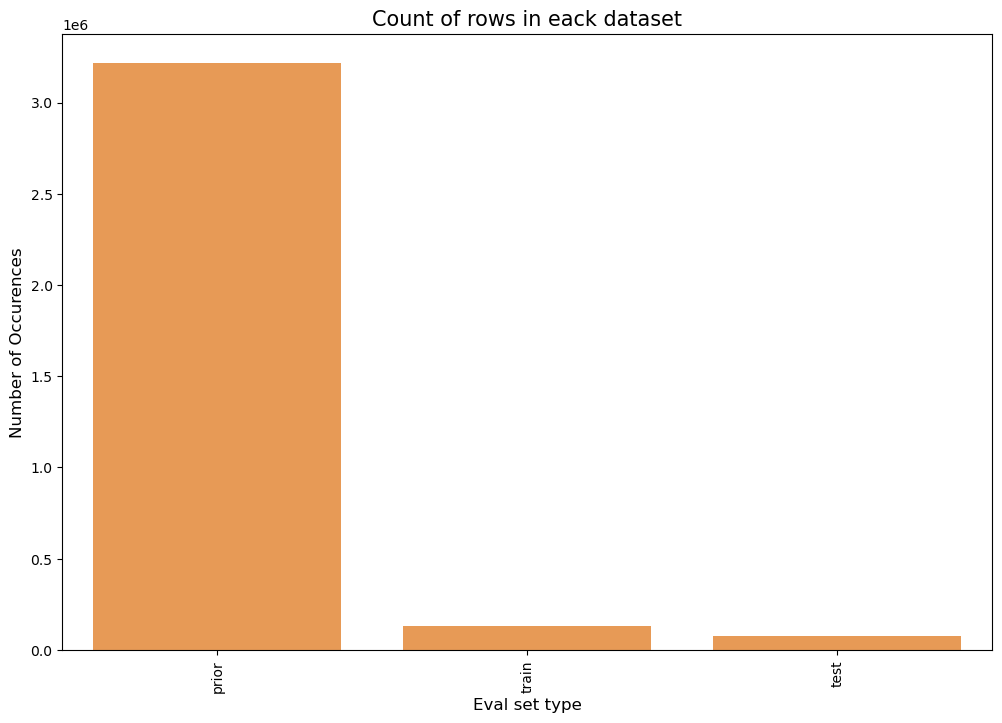

In [16]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1]) # sns.barplot()은 x, y를 명시적으로 전달해야 함.
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in eack dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

총 206,209명의 고객이 있음, 이 중 131,209명의 마지막 구매 고객이 기차 세트로 제공되며 나머지 75,000명의 고객을 예측해야 함.

이제 고객 주문이 4~100건 접수된다는 주장을 검증해보자.

/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_77159/558827441.py:1: FutureWarning: The provided callable <function max at 0x106237c40> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


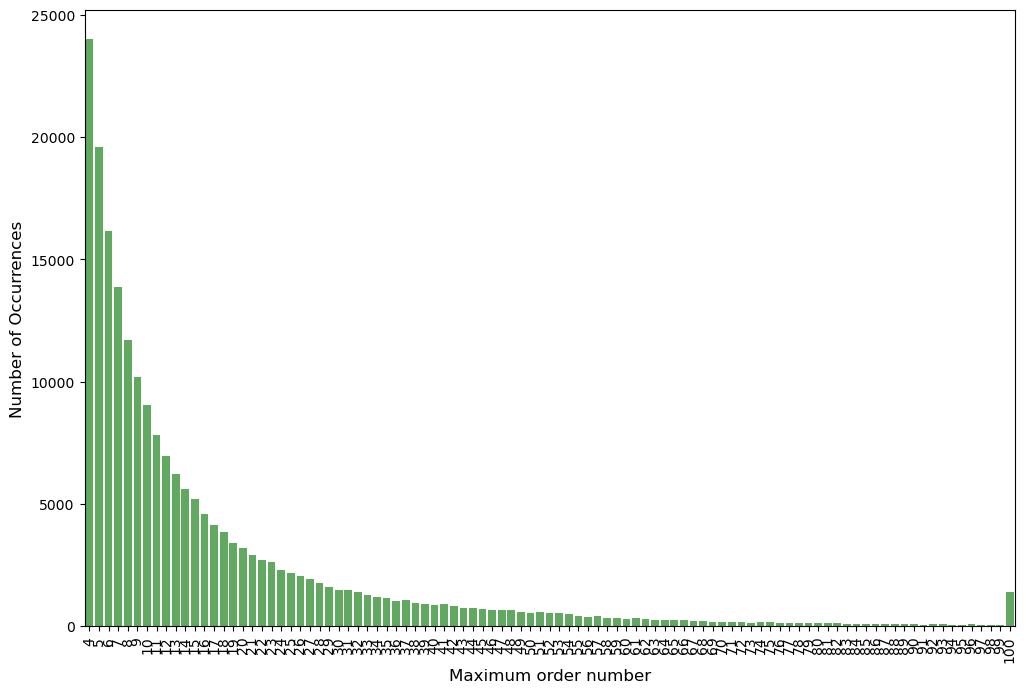

In [19]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

데이터 페이지에 표시된 대로 최대 한도는 100

이제 요일에 따라 주문 습관이 어떻게 변하는지 살펴보자.

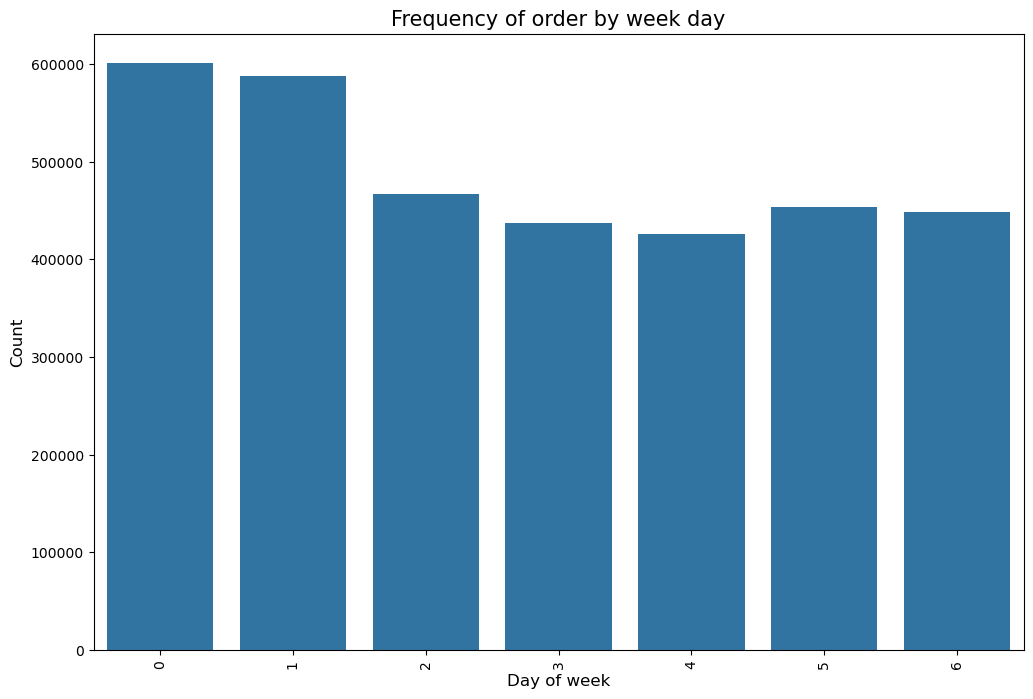

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

주문량이 많고, 수요일에 낮으면 0과 1은 토요일과 일요일로 추측

이제 하루 중 시간에 따른 분포가 어떤지 살펴보자.

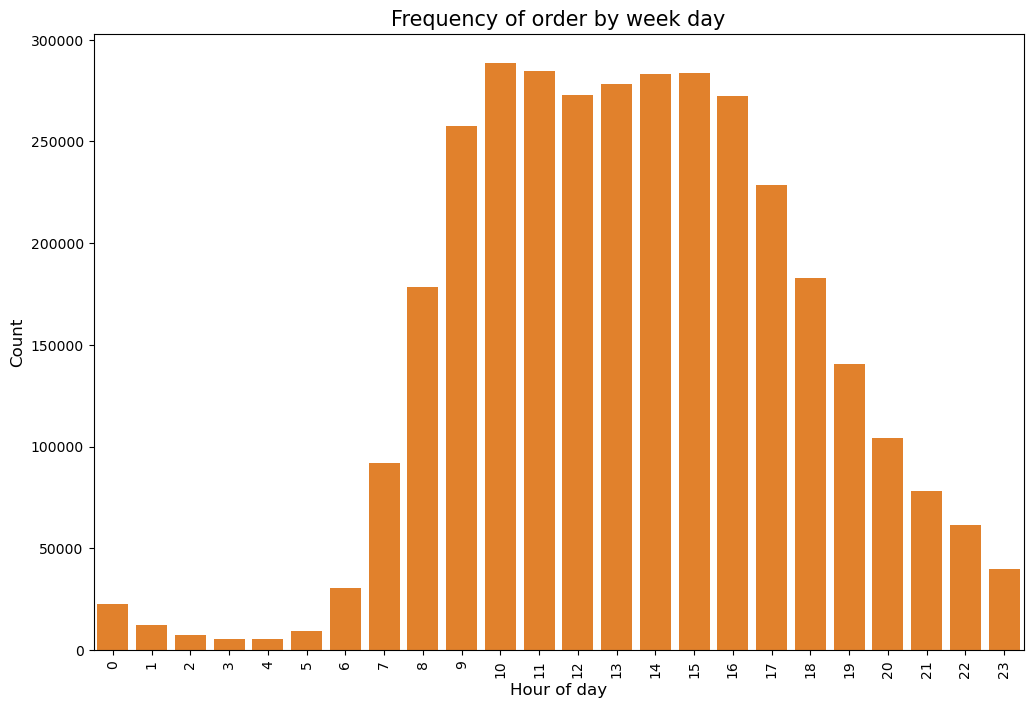

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

대부분의 주문은 낮 시간대에 이루어짐.

이제 요일과 시간을 결합하여 분포를 살펴보자.

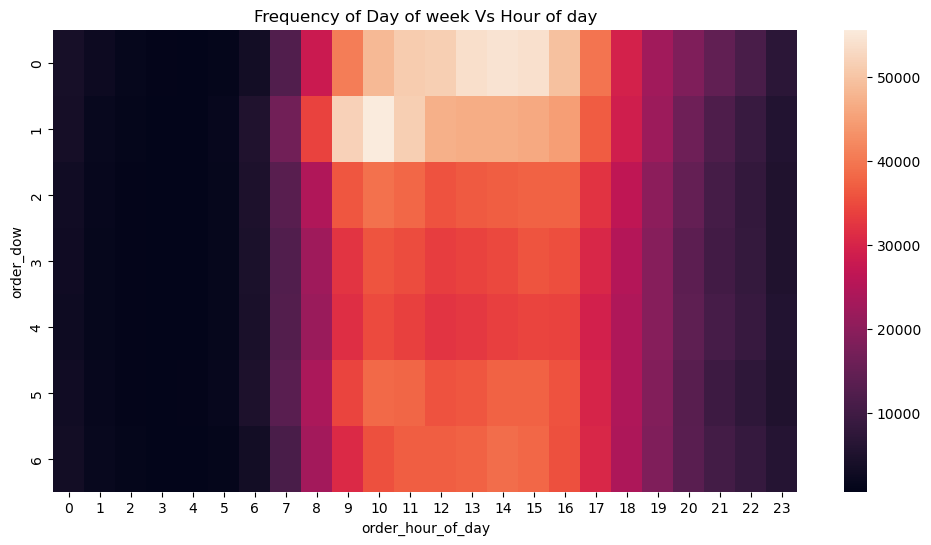

In [25]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')
# pivot()을 사용할 때는 index=, columns=, values=를 명시해야 함.

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

토요일 저녁과 일요일 아침이 주문하기 가장 좋은 시간으로 보임.

이제 주문 간의 시간 간격을 확인해보자.

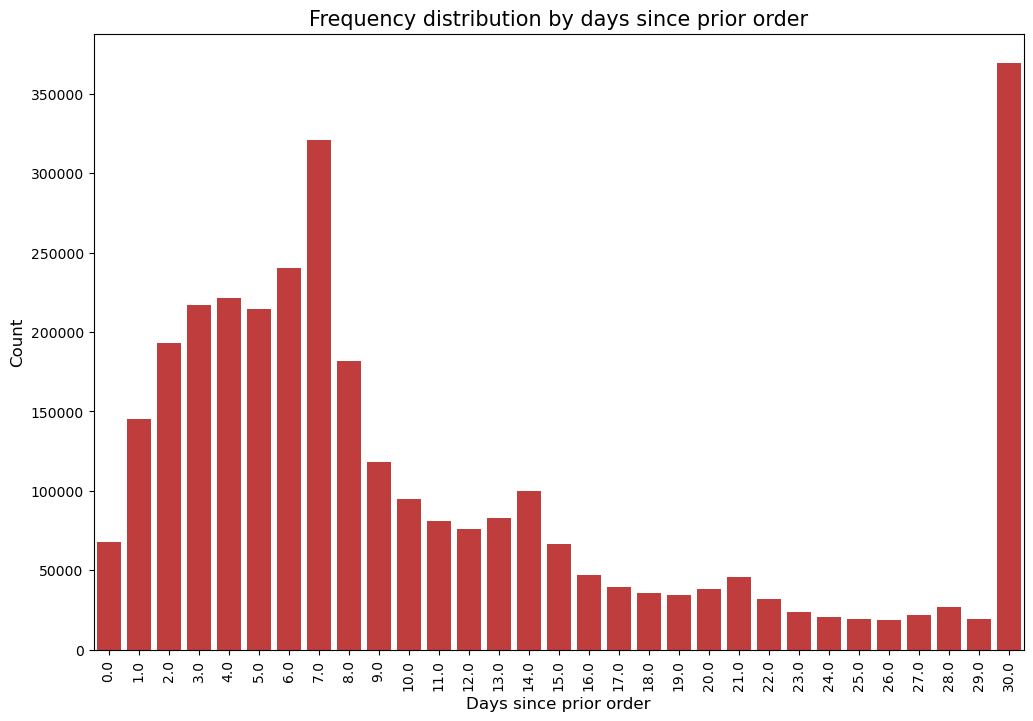

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

고객들이 일주일에 한 번씩 주문하는 것 같음(7일에 피크) 또는 한 달에 한 번씩 주문하는 것 같음(30일에 피크)
또한 14일, 21일, 28일(주간 간격)에 더 작은 피크 볼 수 있음.

우리의 목표는 재주문을 파악하는 것이므로, 이전 세트와 기차 세트의 재주문 비율을 확인해보자.

In [29]:
# percentage of re-orders in prior set
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [30]:
# percentage of re-orders in train set
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

평균적으로 주문한 제품의 약 59%가 재주문된 제품

재주문된 제품 없음:

이제 59%의 제품이 재주문된 것을 확인했으니, 어떤 제품도 재주문되지 않는 상호아도 발생할 것. 지금 확인해보자

In [37]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #iloc[] 정수 기반 인덱싱, loc[] 라벨 기반 인덱싱
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_77159/2012630991.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #iloc[] 정수 기반 인덱싱, loc[] 라벨 기반 인덱싱


reordered
1    0.879151
0    0.120849
Name: count, dtype: float64

In [39]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #iloc[] 정수 기반 인덱싱, loc[] 라벨 기반 인덱싱
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_77159/2552845074.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #iloc[] 정수 기반 인덱싱, loc[] 라벨 기반 인덱싱


reordered
1    0.93444
0    0.06556
Name: count, dtype: float64

이전 세트의 주문의 약 12%는 재주문된 품목이 없는 반면, 기차 세트는 6.5%입니다.

이제 각 주문에서 구매한 제품의 수를 살펴보자.

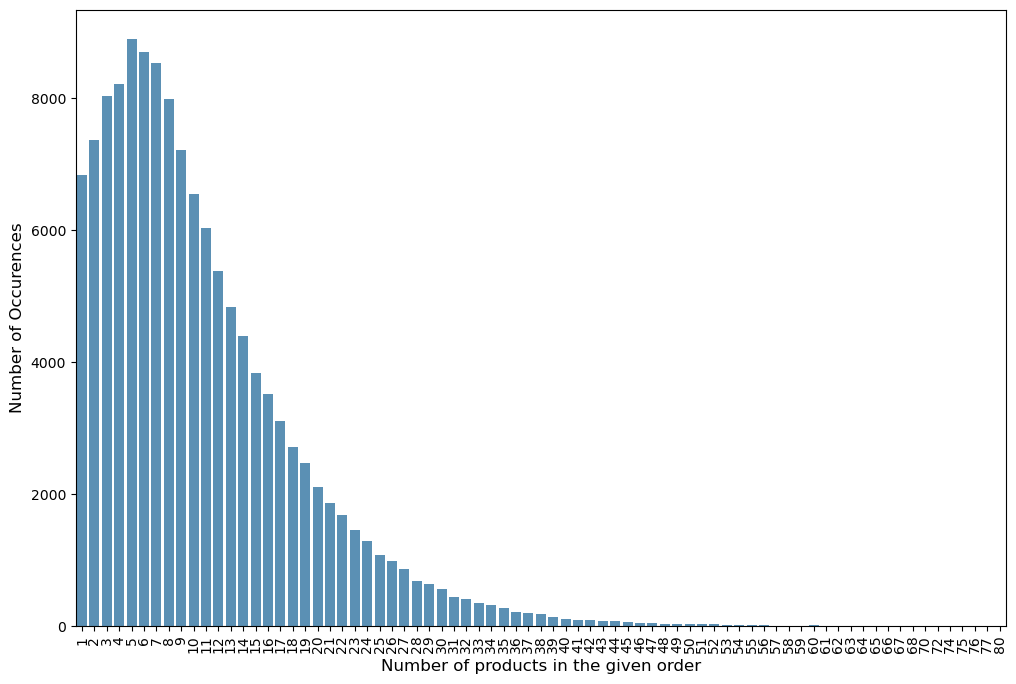

In [43]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

최대값이 5이 오른쪽 꼬리 분포

제품 세부 사항을 살펴보기 전에 다른 세 가지 파일도 살펴보자.

In [45]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [46]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [47]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


이제 이 제품 세부 정보를 order_prior 세부 정보와 병합해보자.

In [49]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [50]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


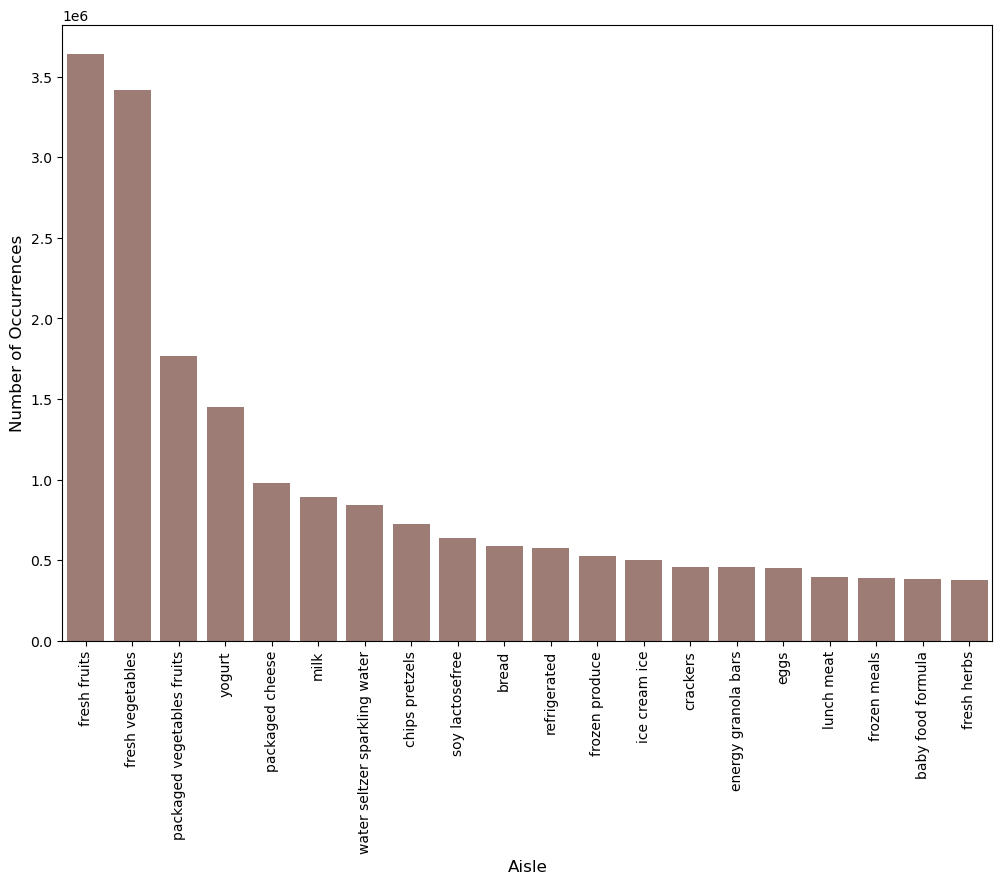

In [51]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

상위 두 개의 품목은 fresh fruits과 fresh vegetables임.

부서 분포 :

이제 부서별 분포를 확인해보자.

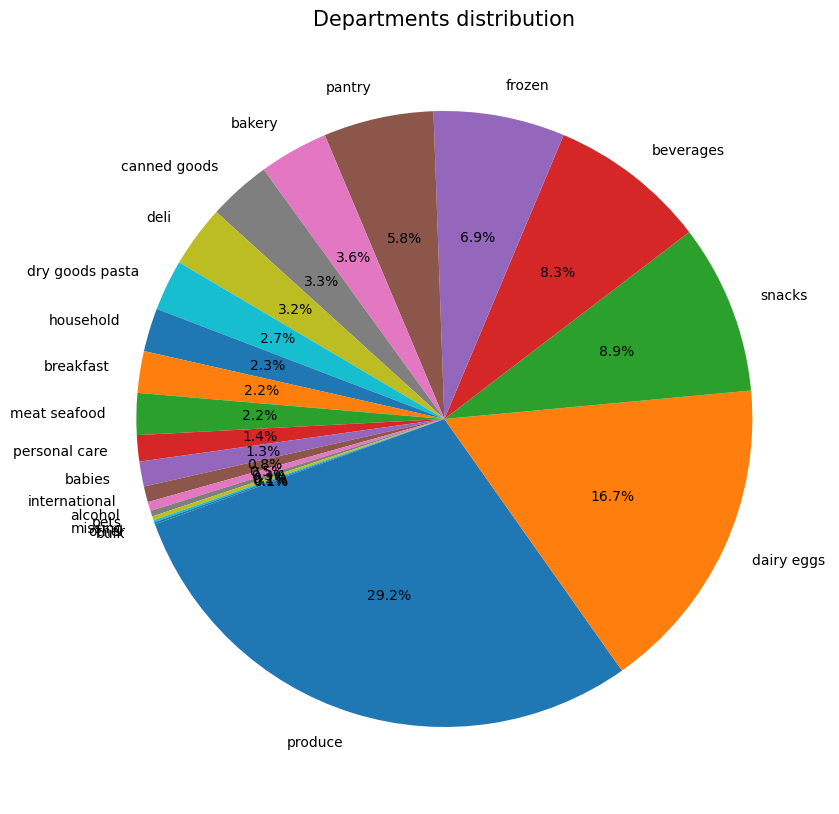

In [53]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels=(np.array(temp_series.index))
sizes=(np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

products가 가장 큰 부서임.

이제 각 부서 당 재주문 비율을 확인해보자.

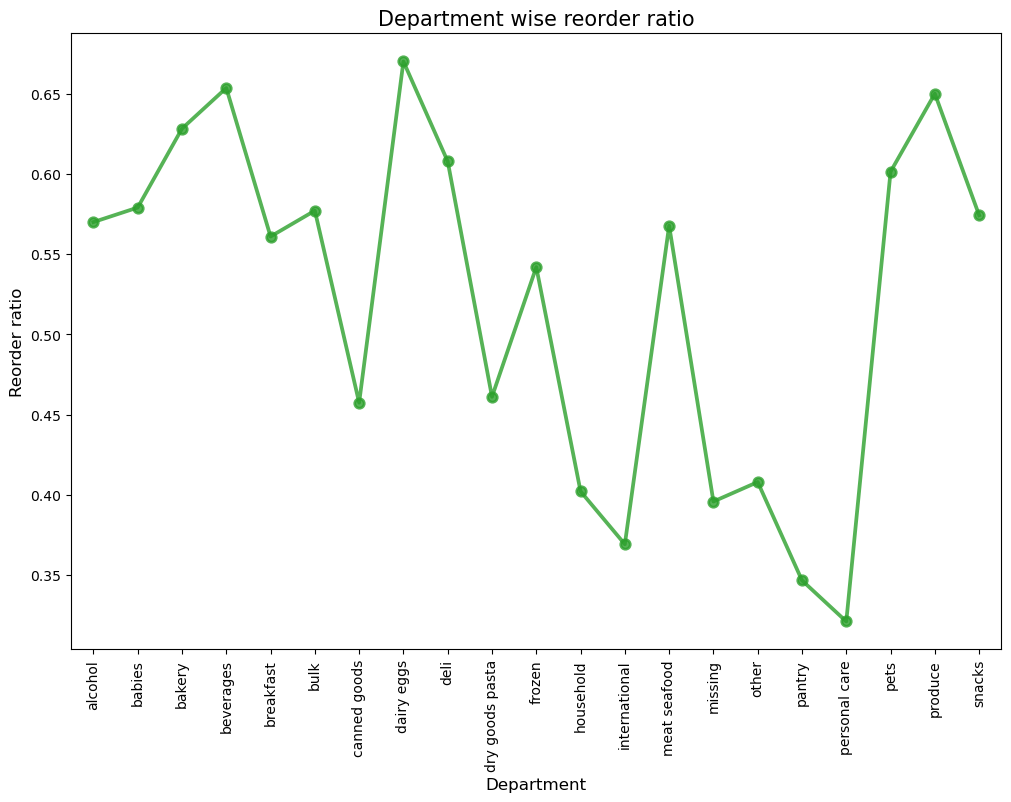

In [55]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal care가 가장 낮은 재주문 비율을 지니고, dairy eggs가 가장 높은 재주문 비율을 가짐.

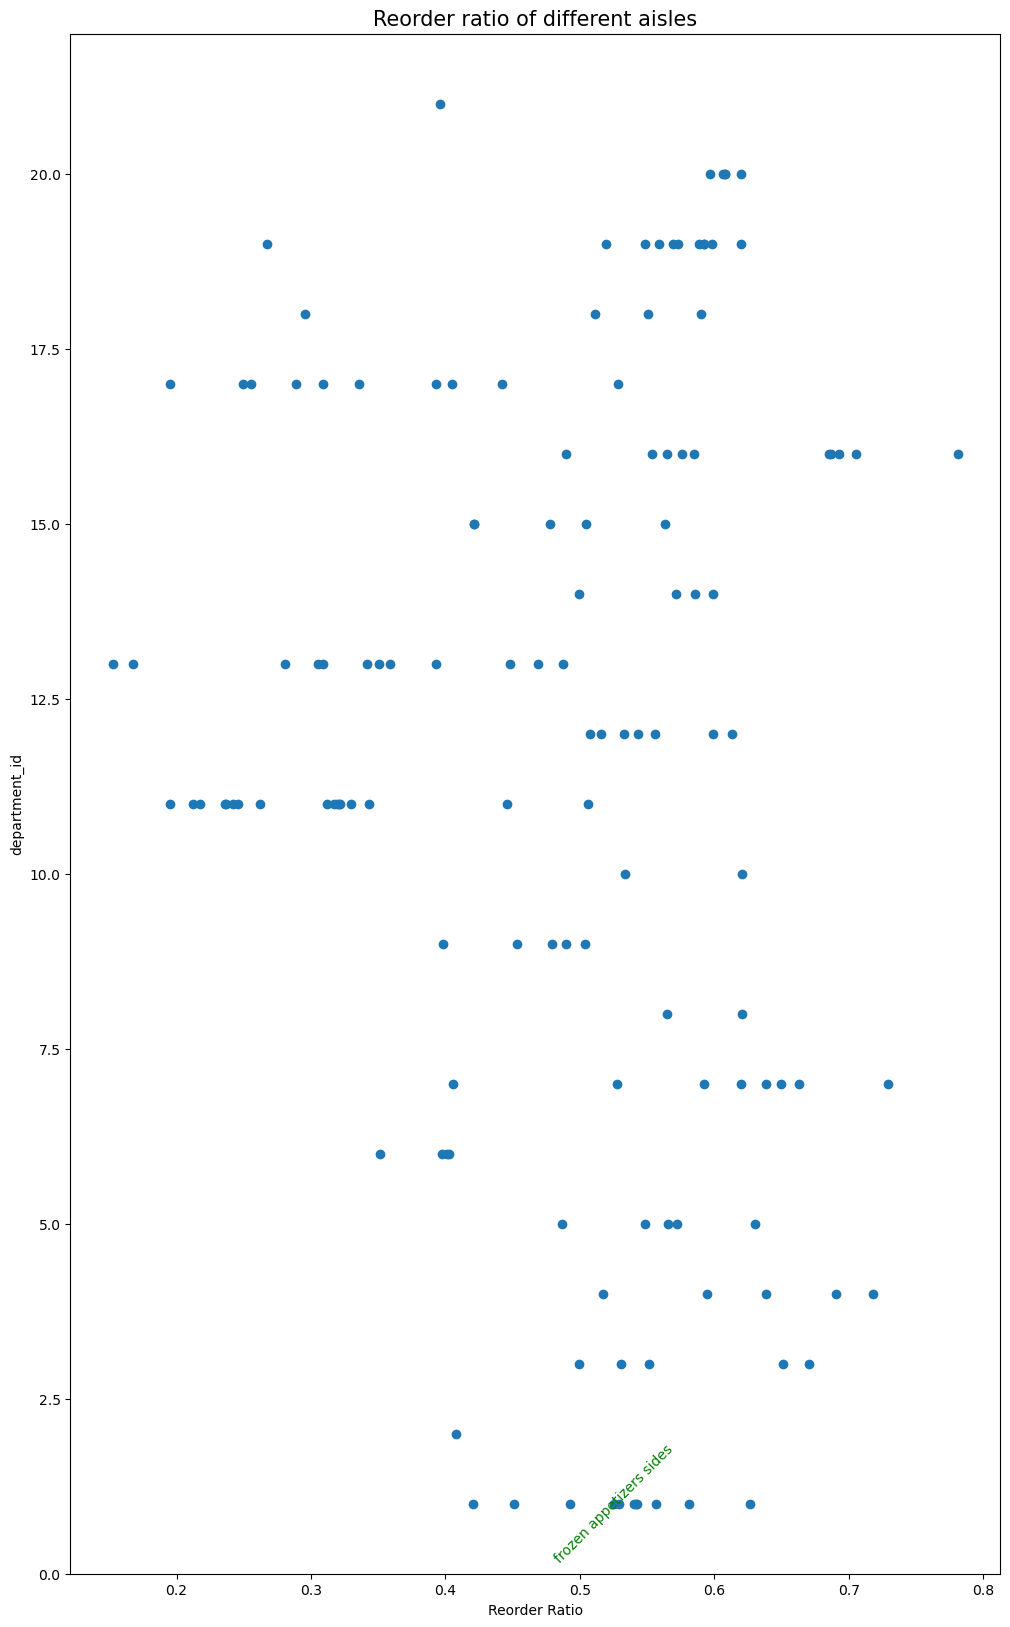

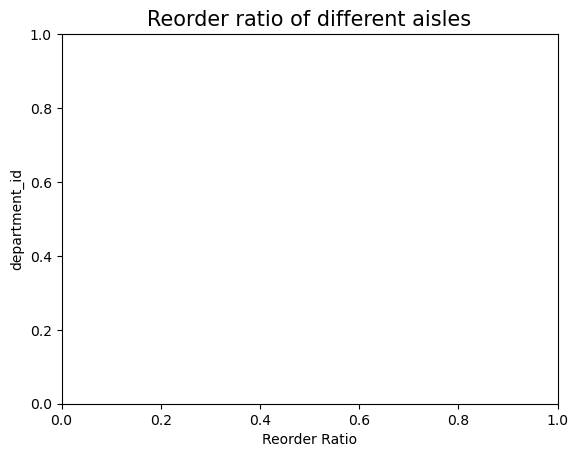

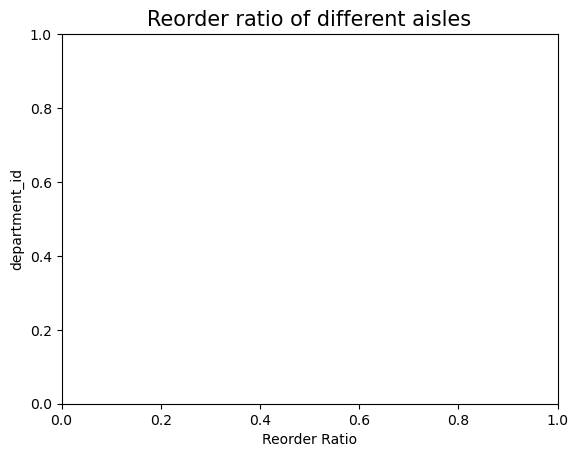

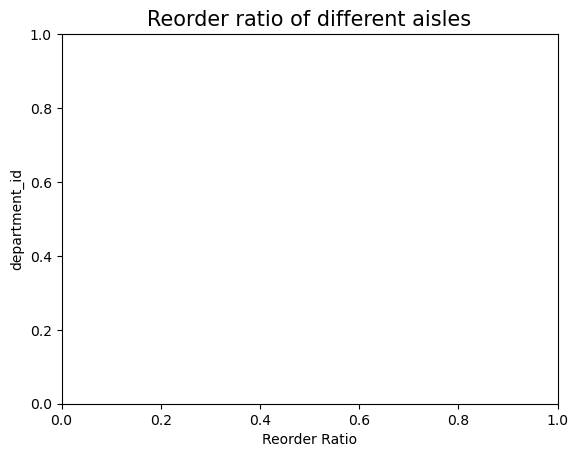

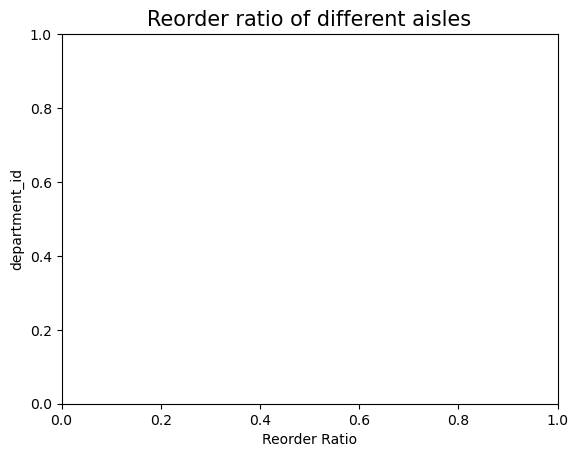

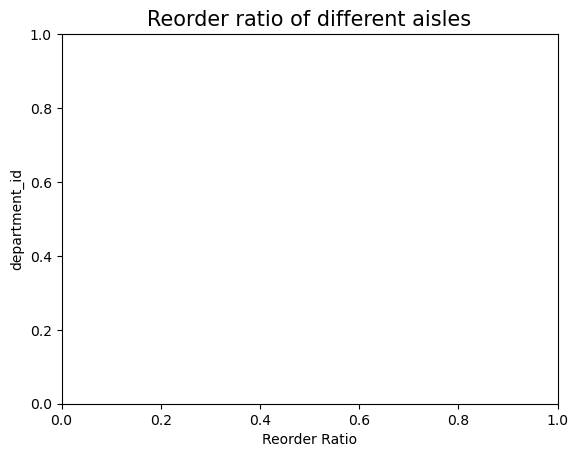

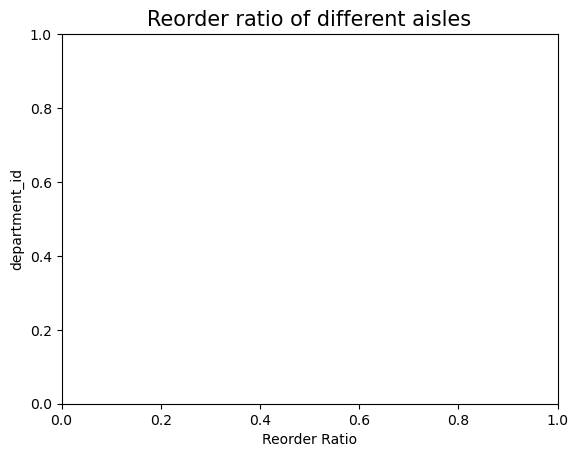

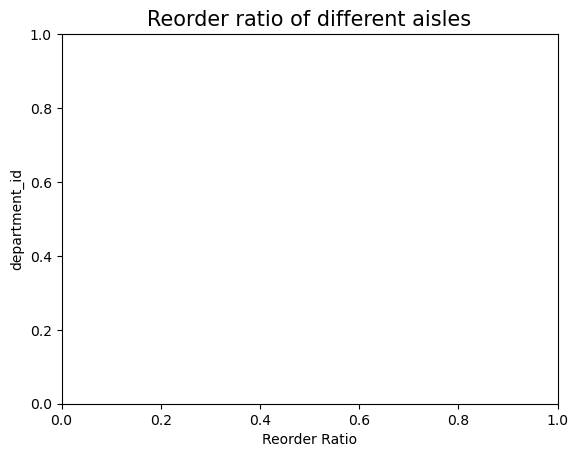

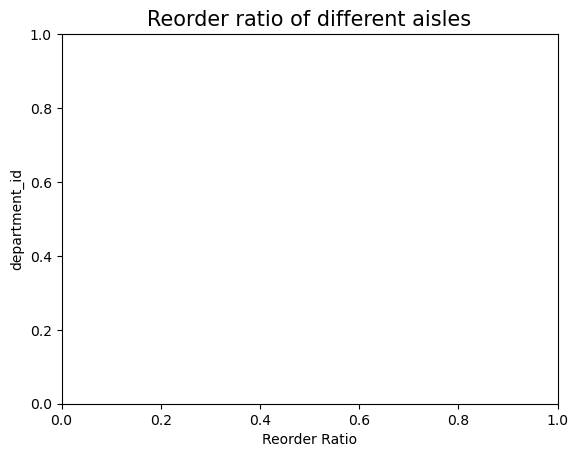

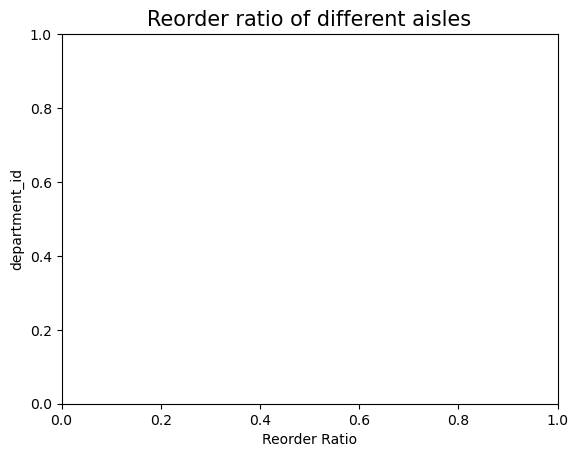

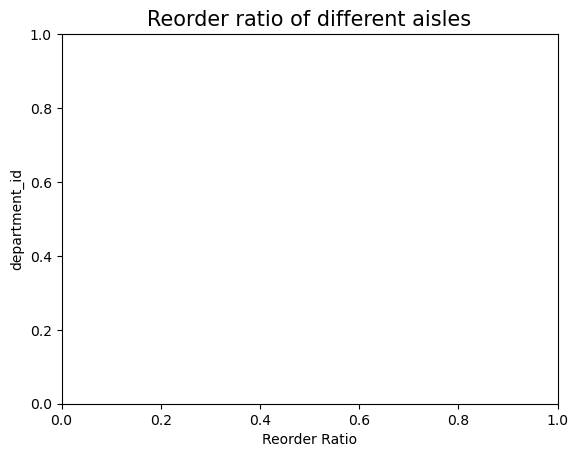

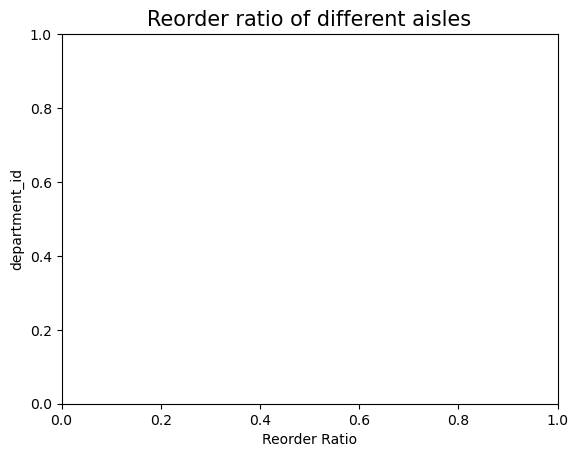

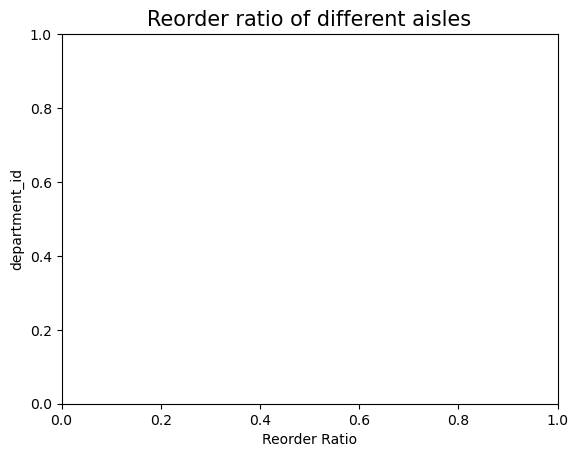

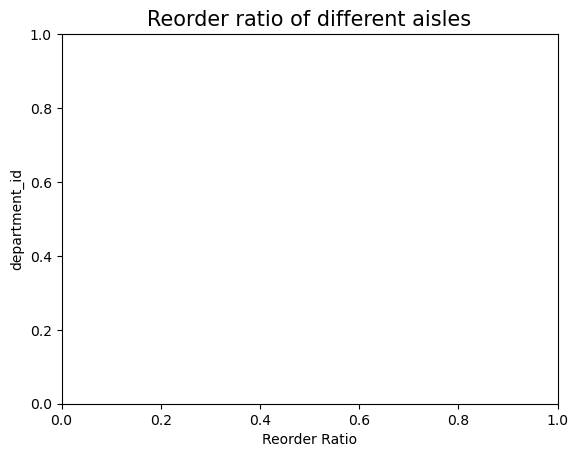

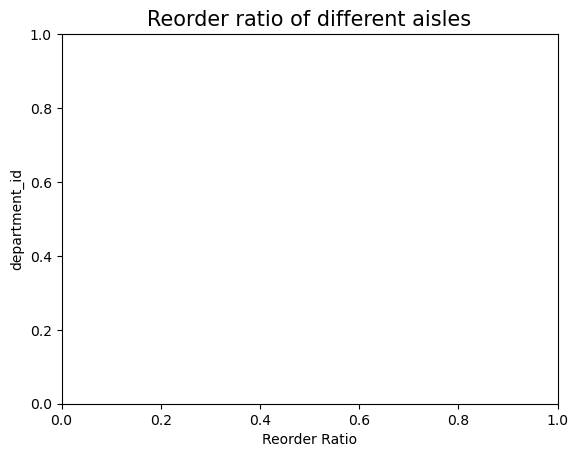

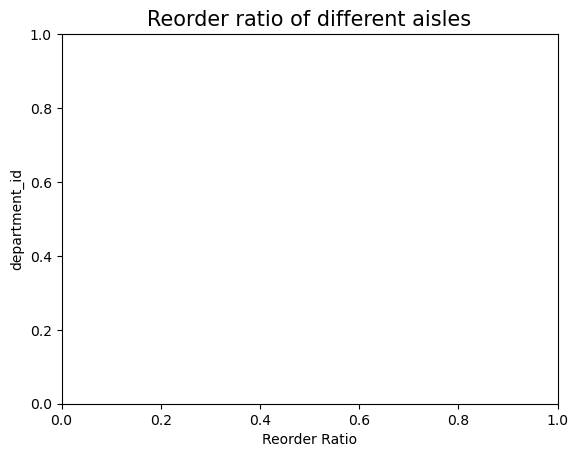

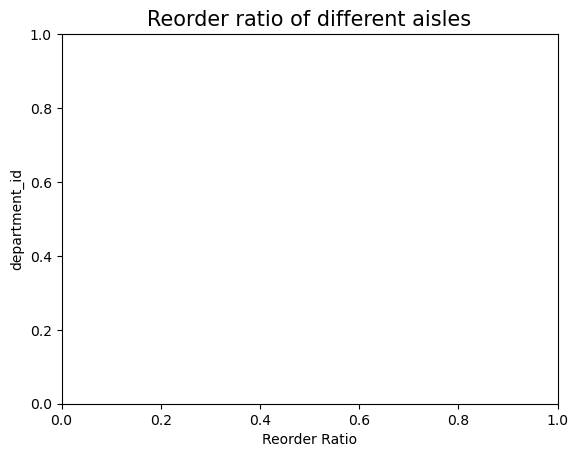

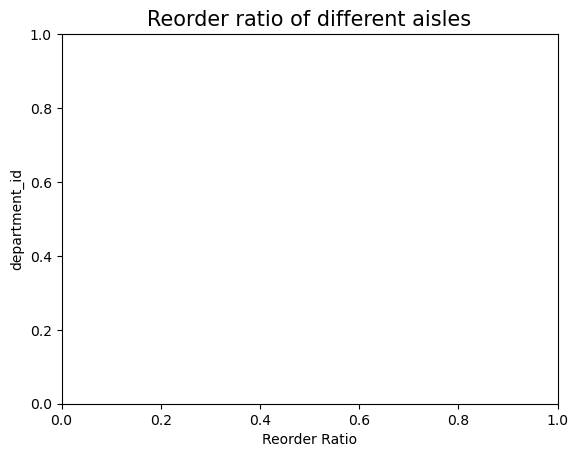

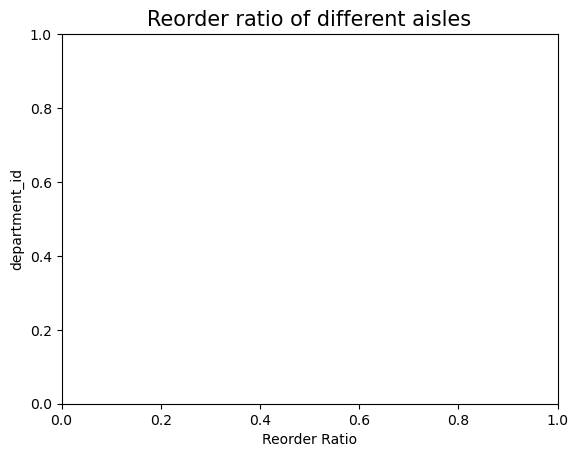

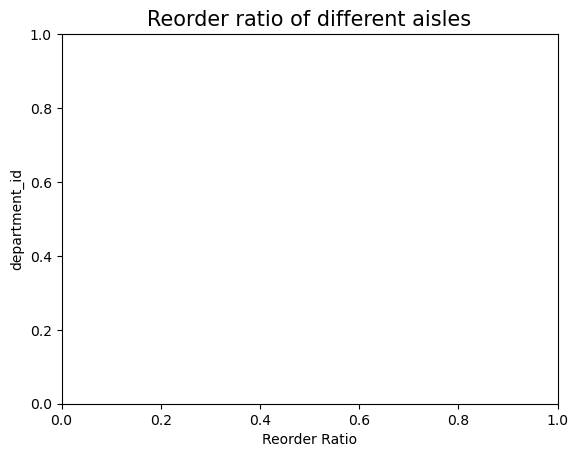

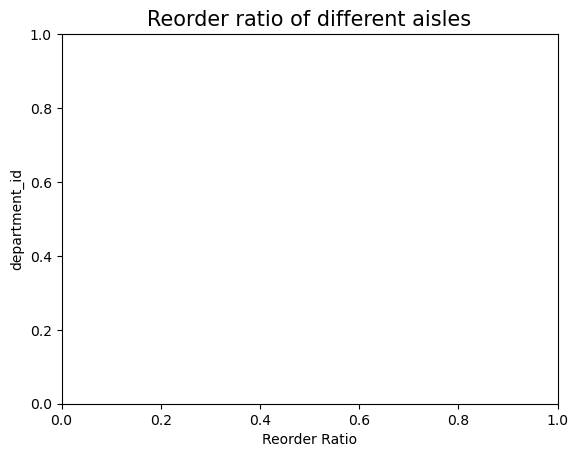

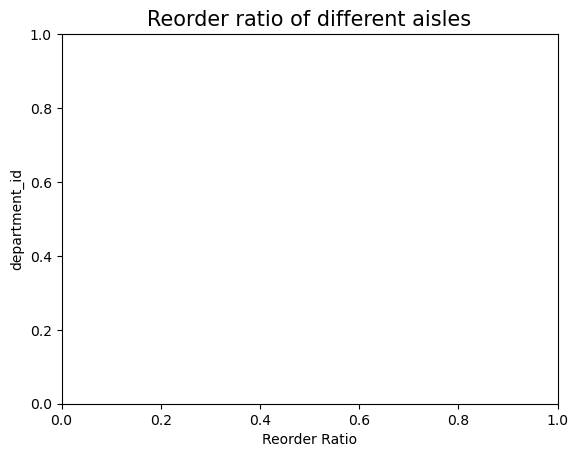

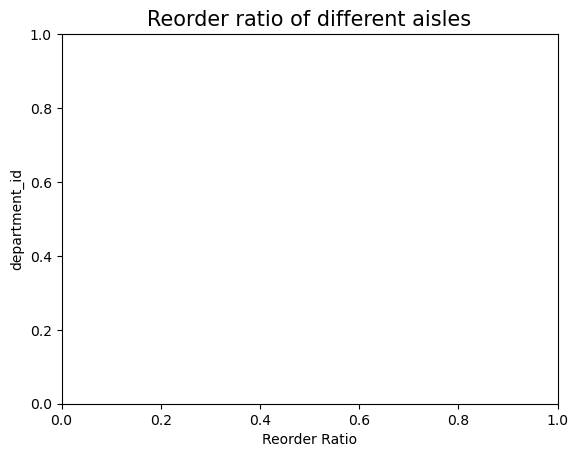

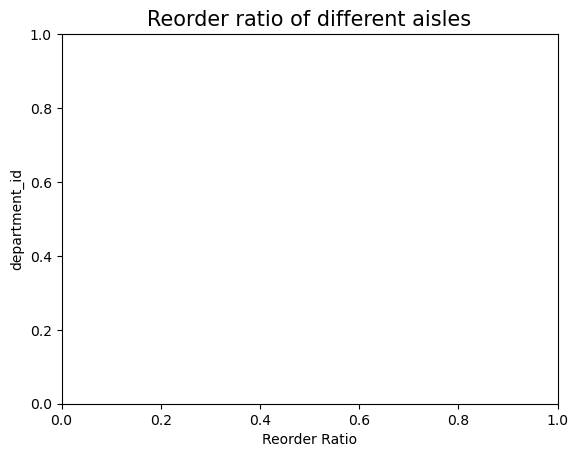

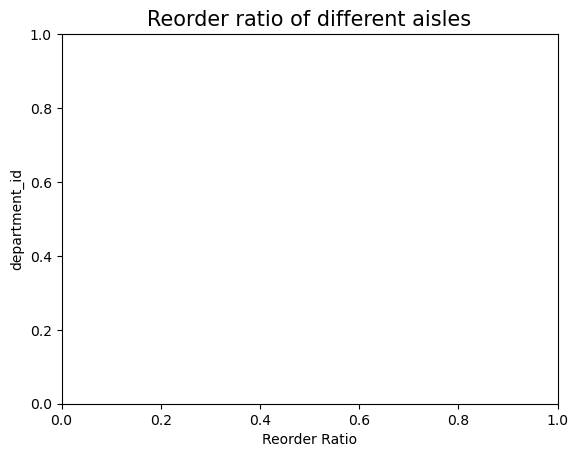

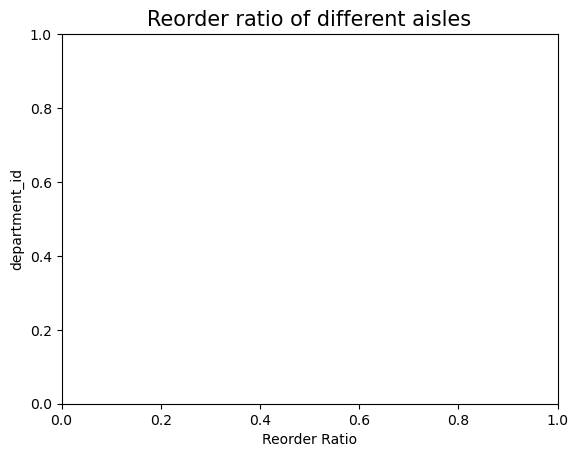

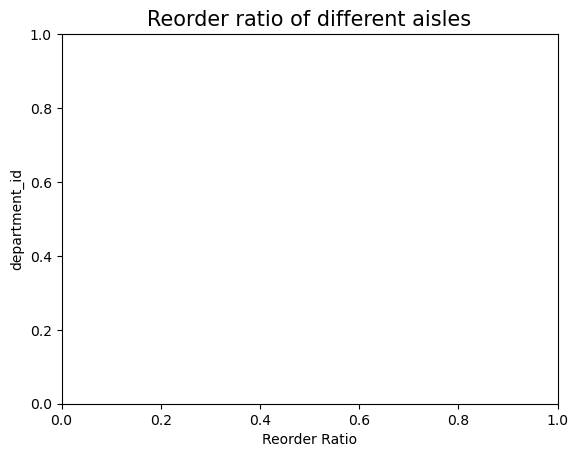

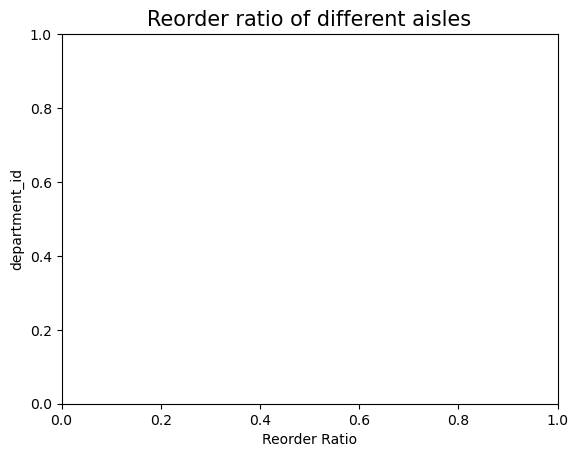

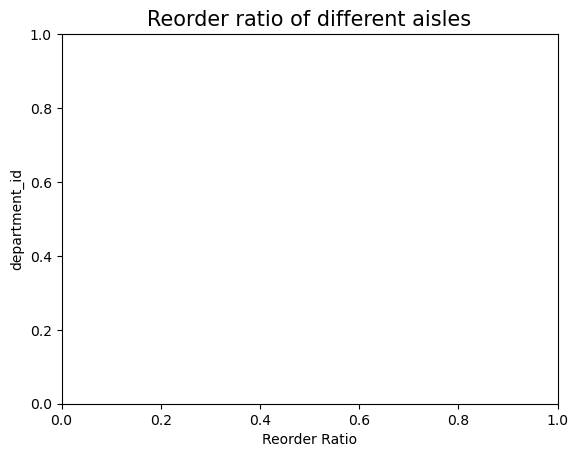

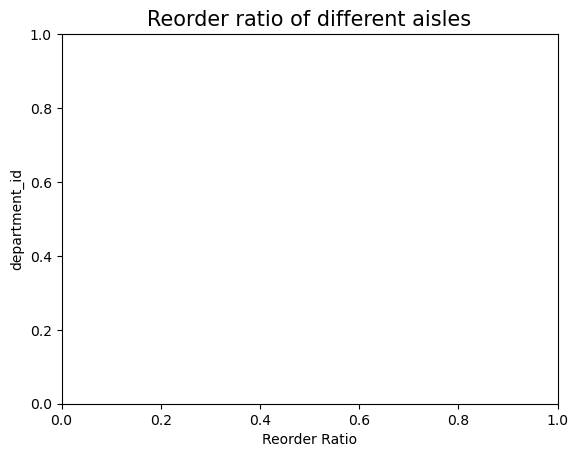

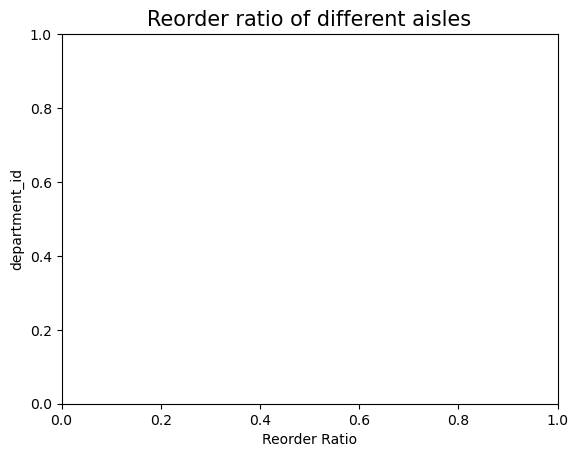

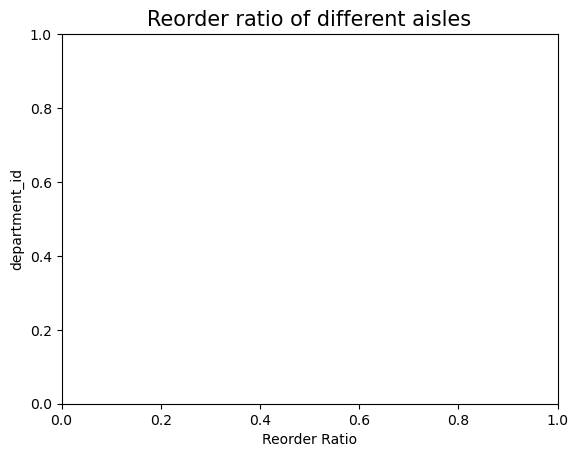

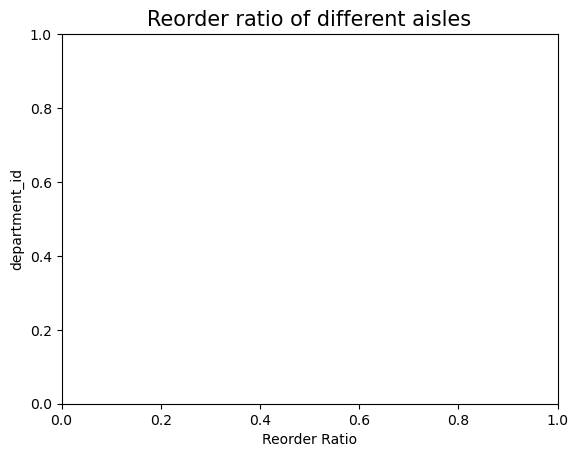

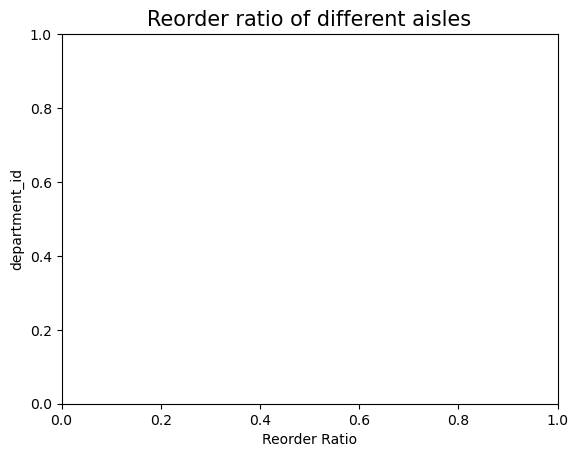

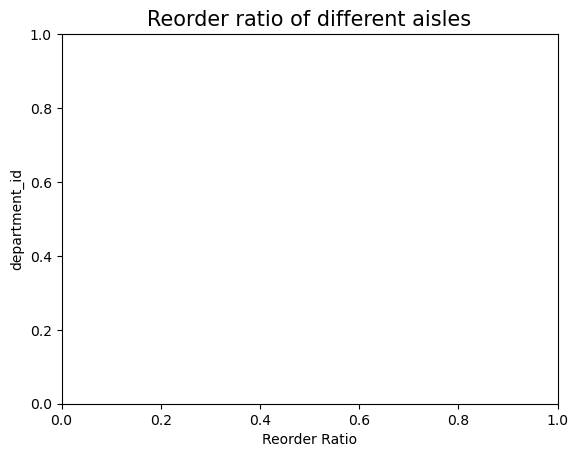

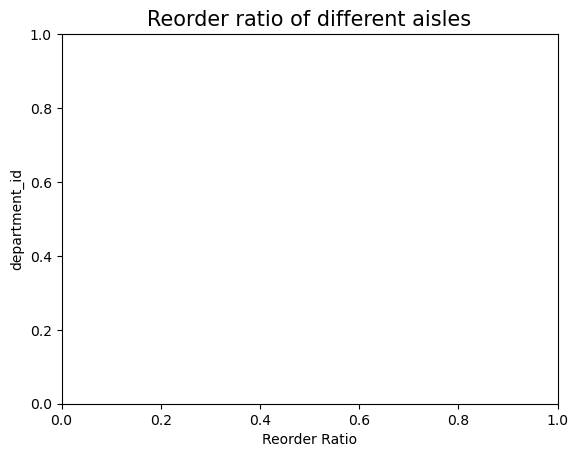

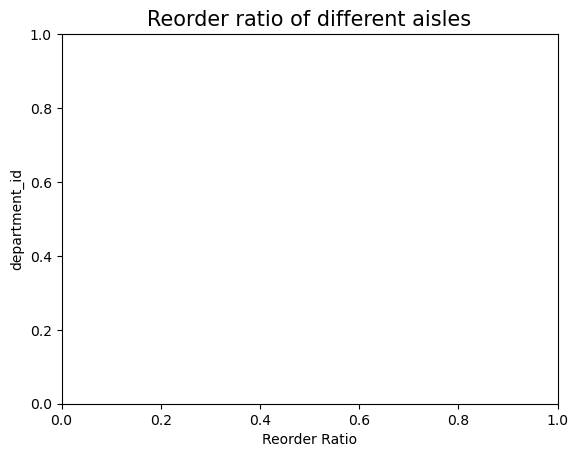

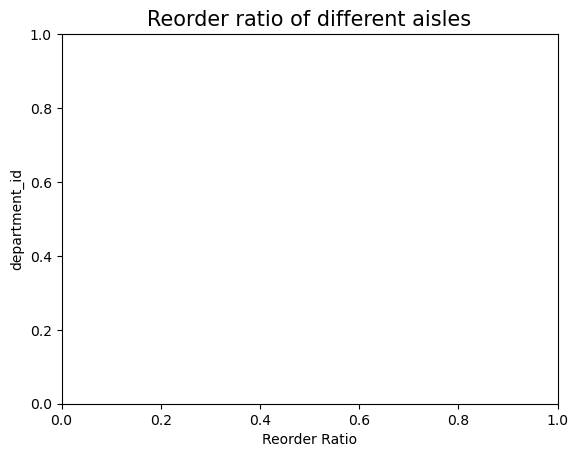

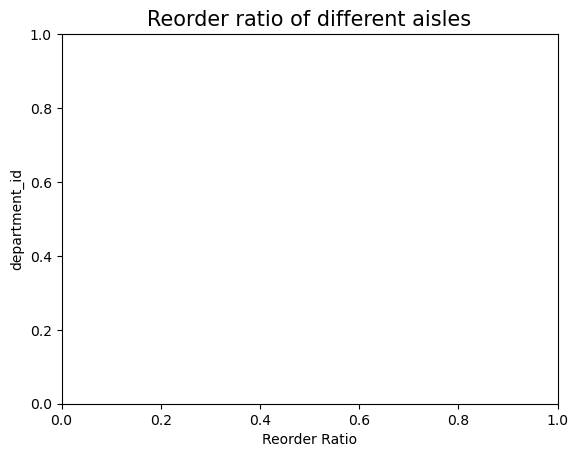

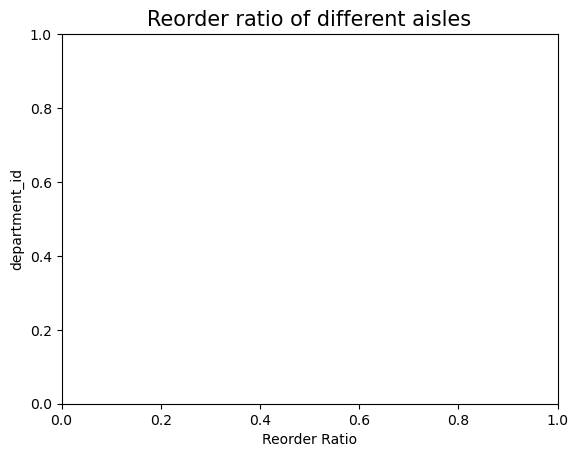

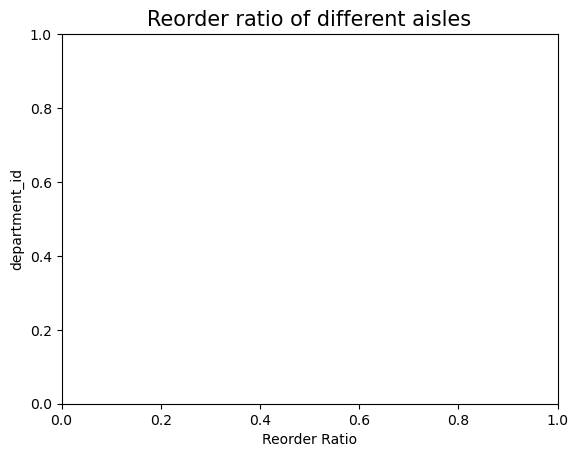

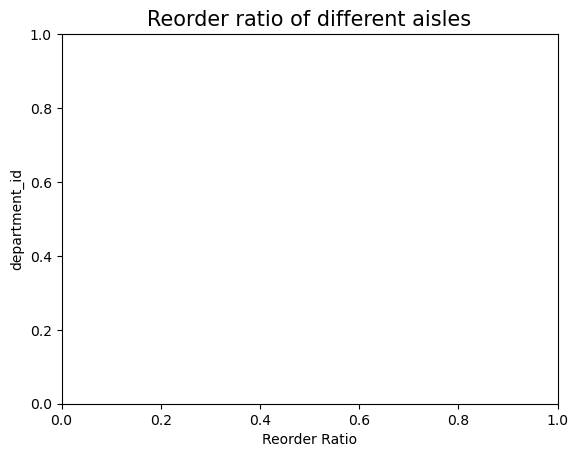

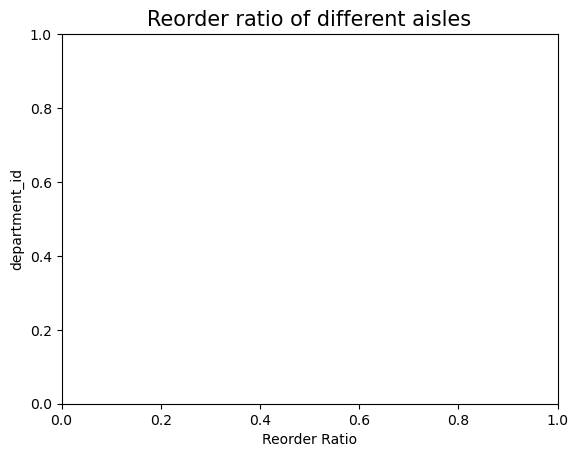

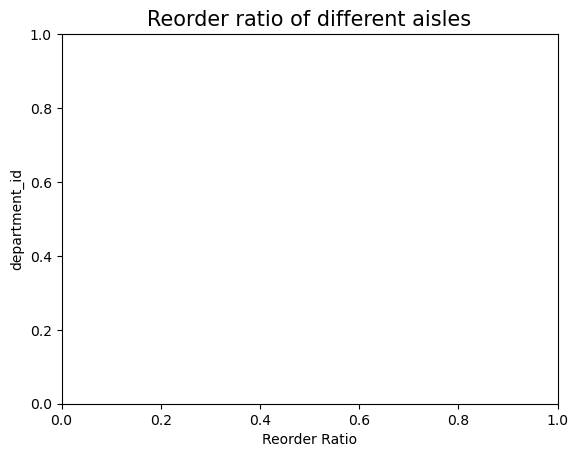

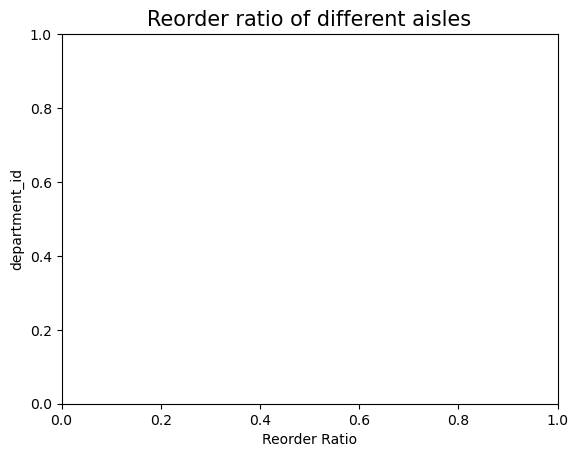

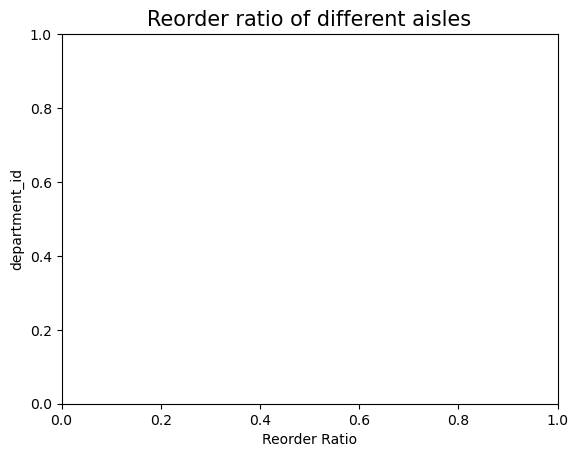

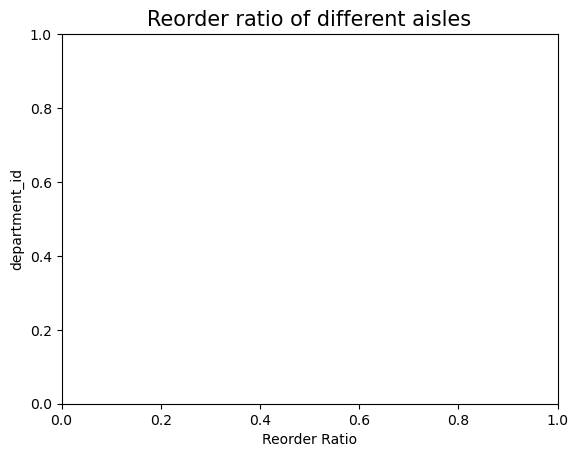

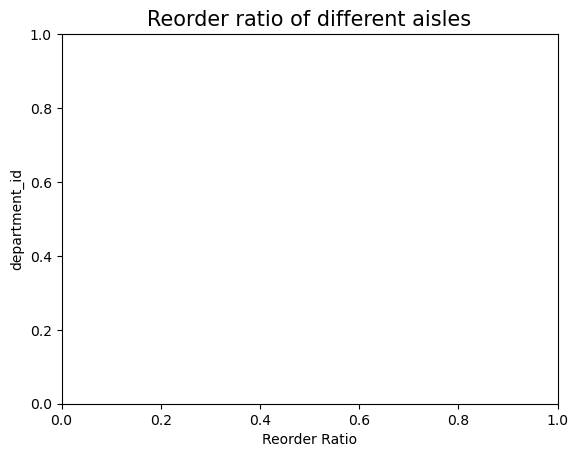

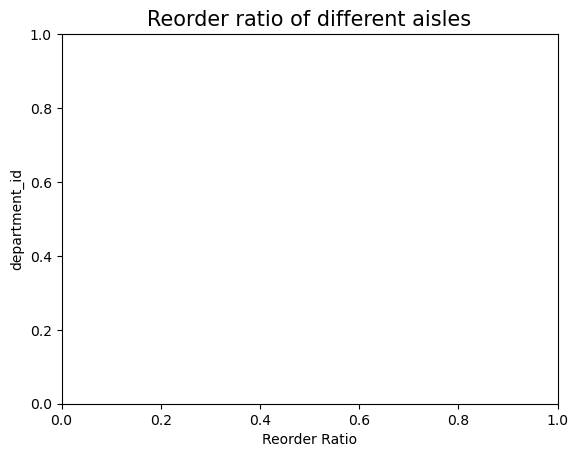

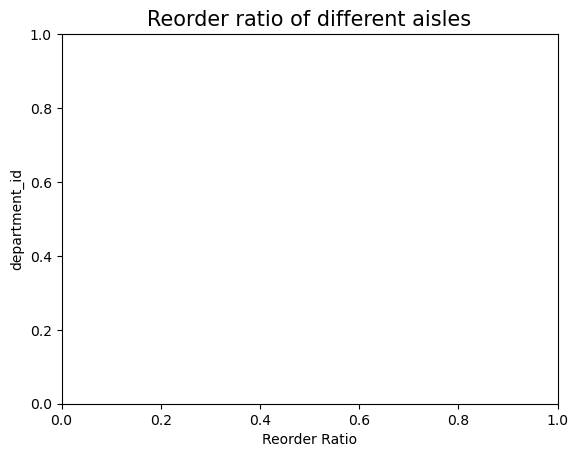

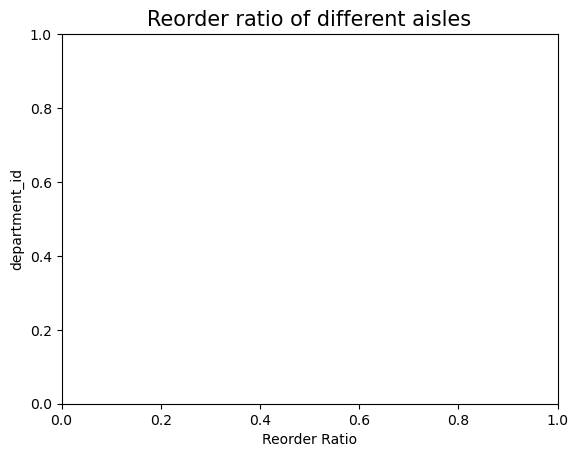

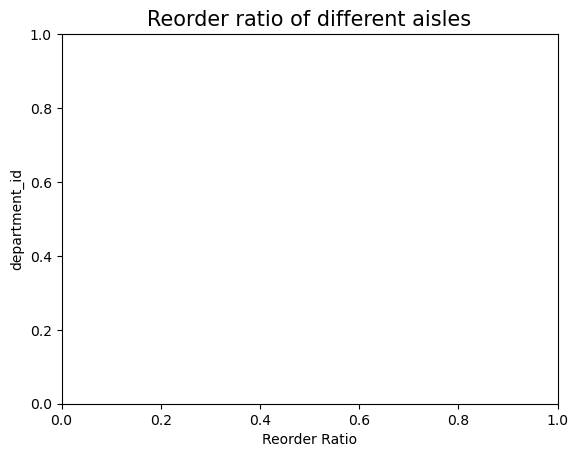

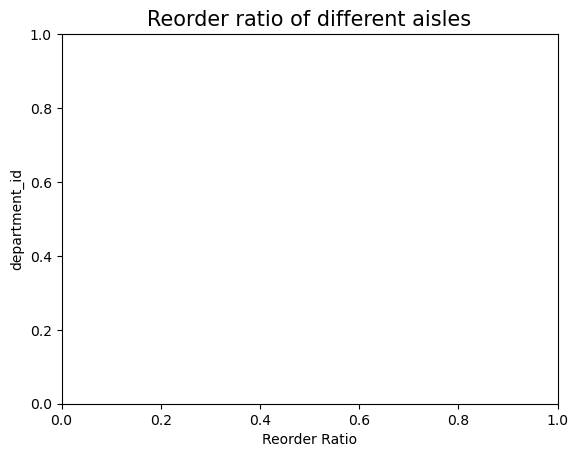

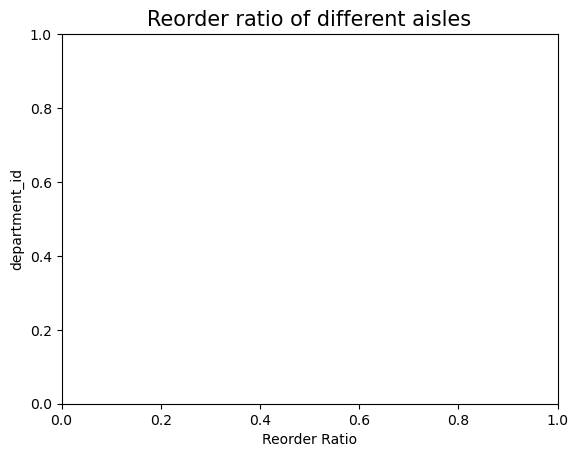

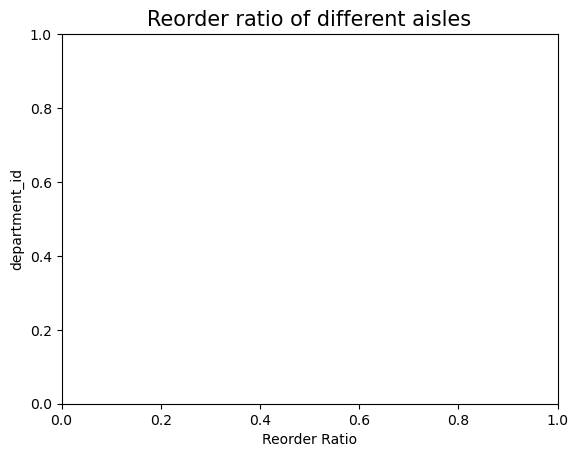

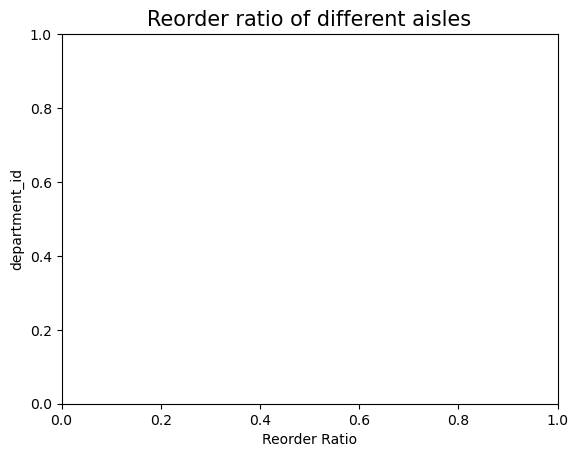

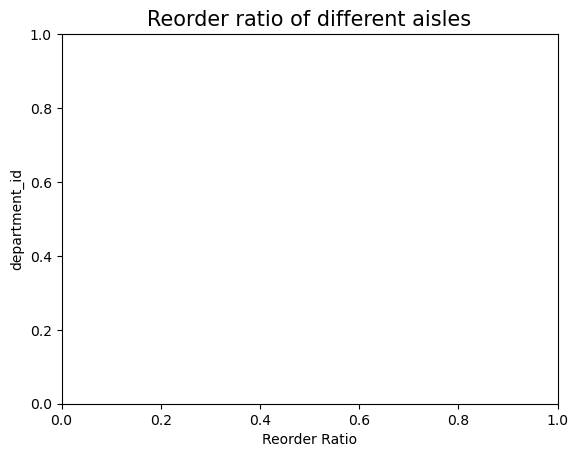

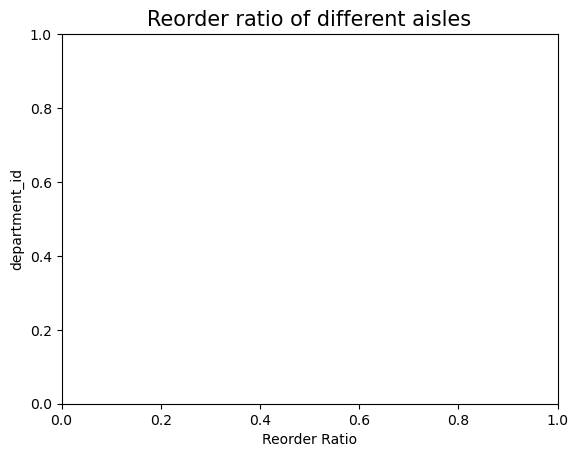

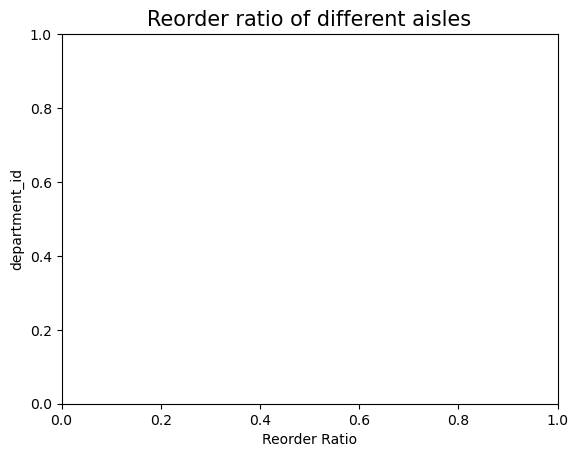

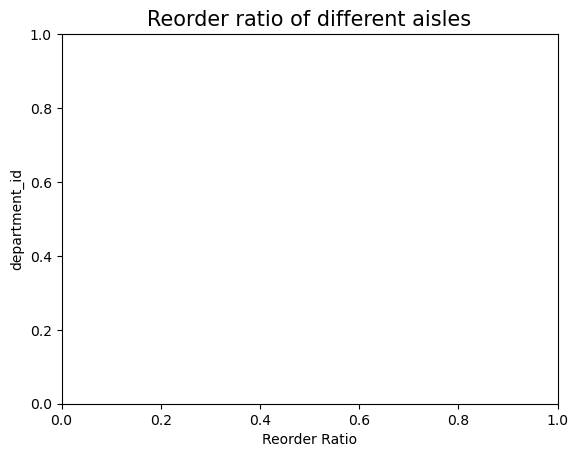

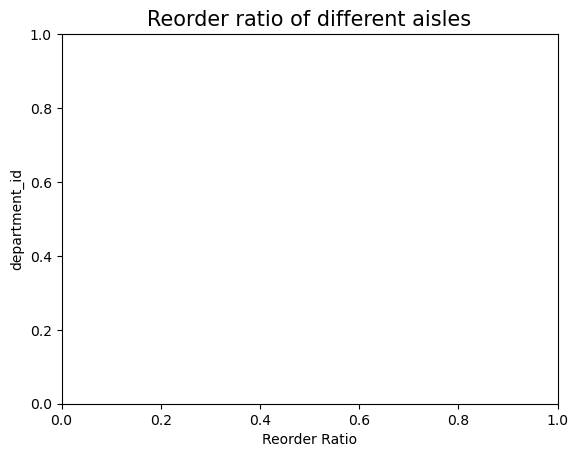

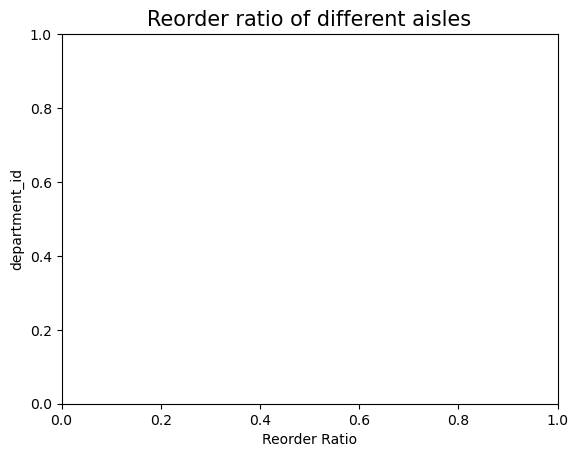

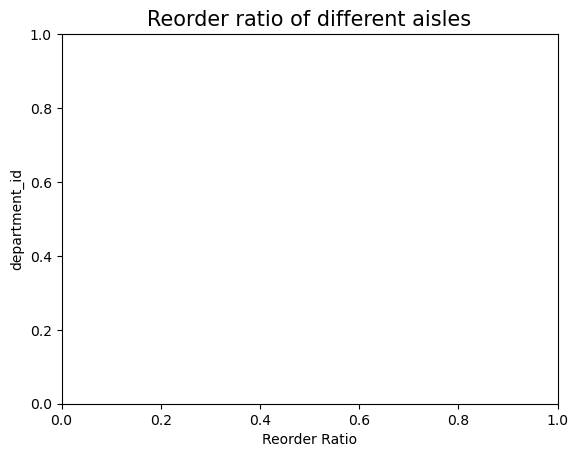

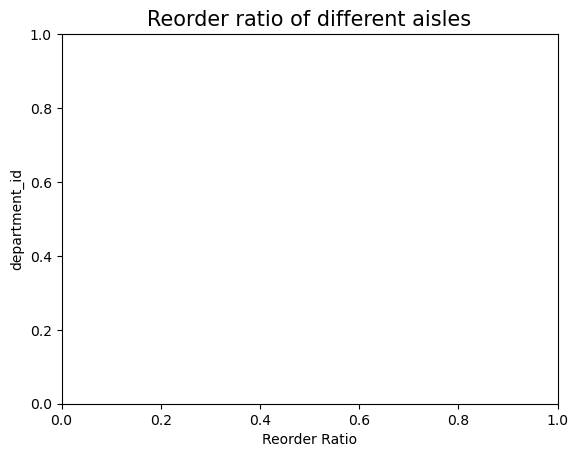

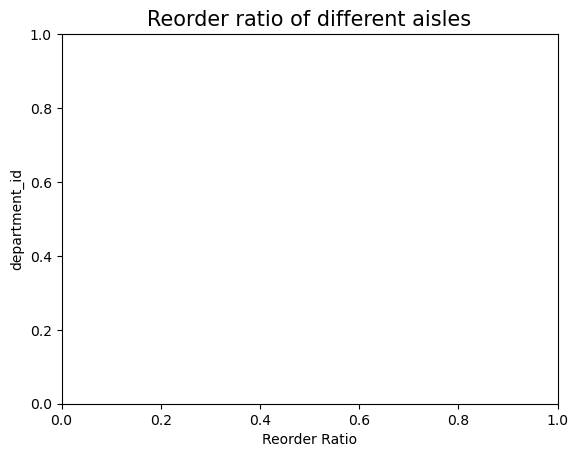

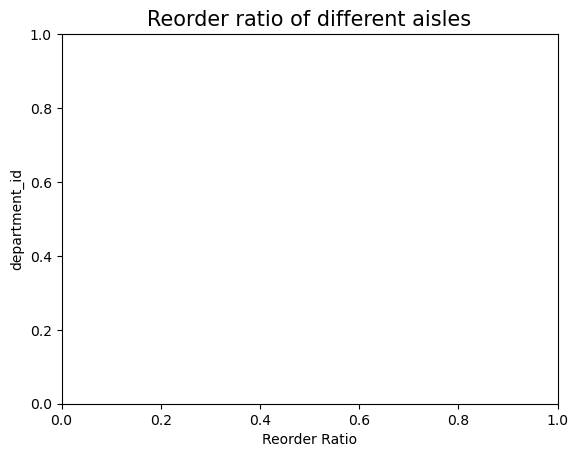

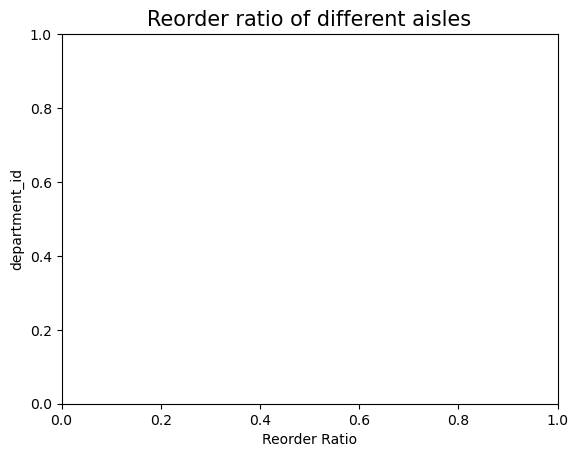

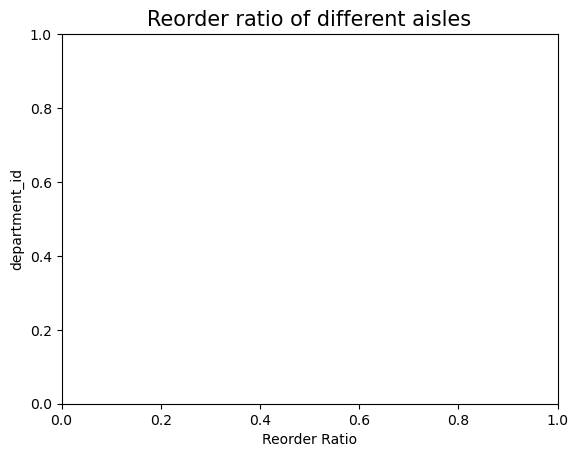

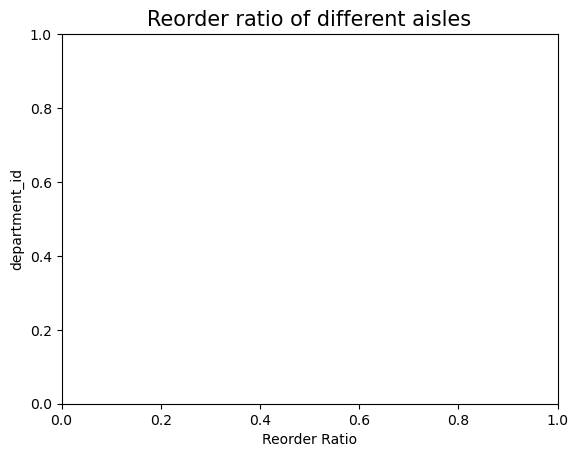

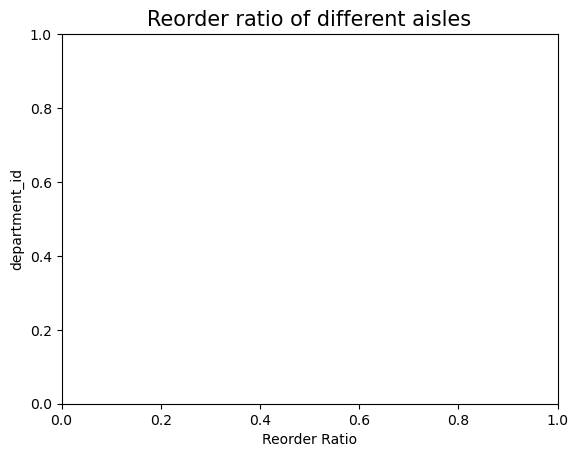

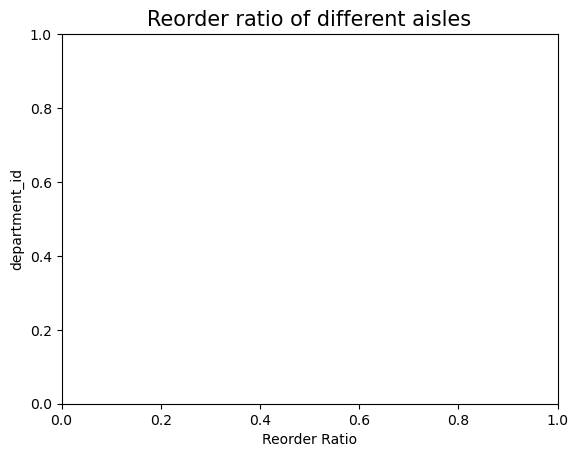

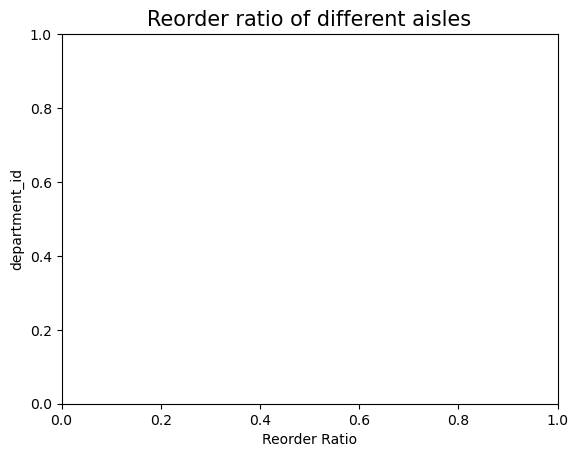

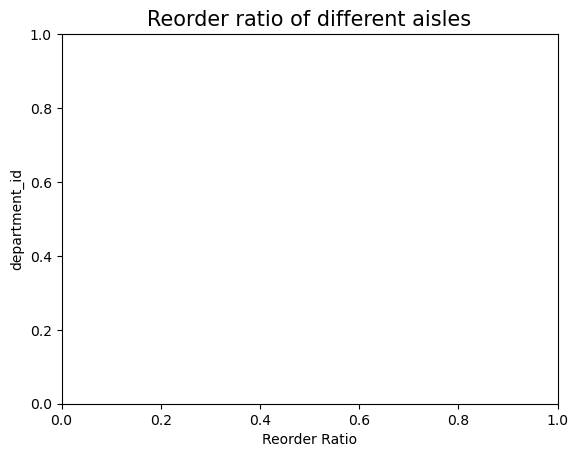

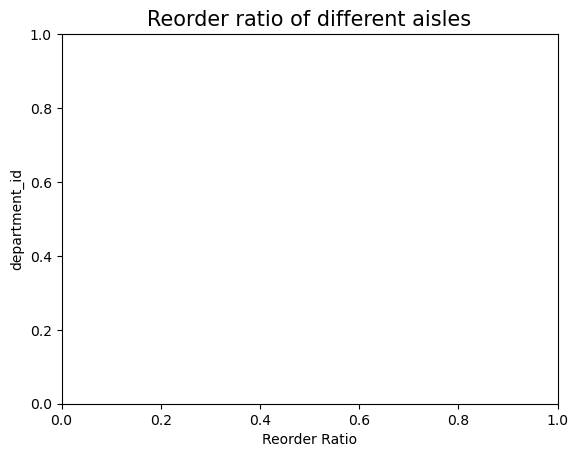

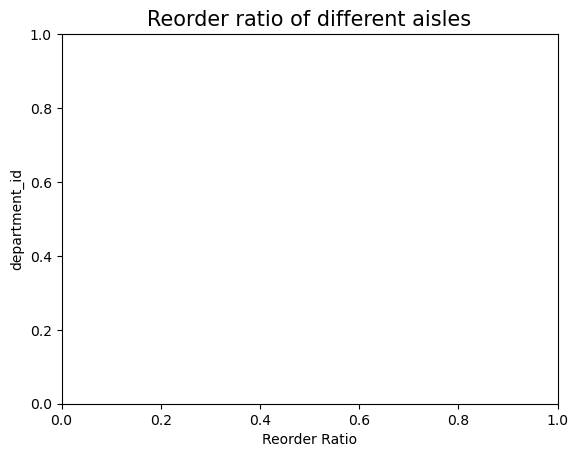

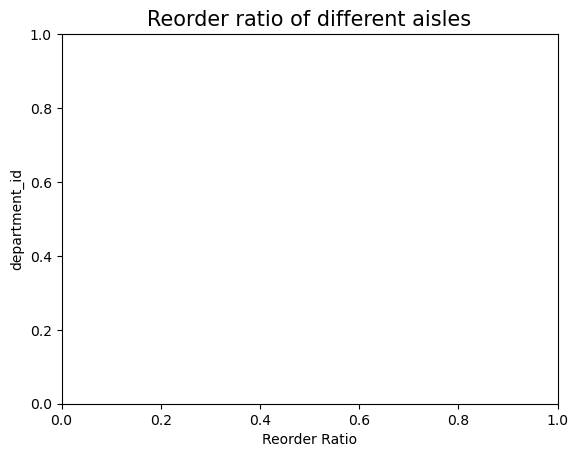

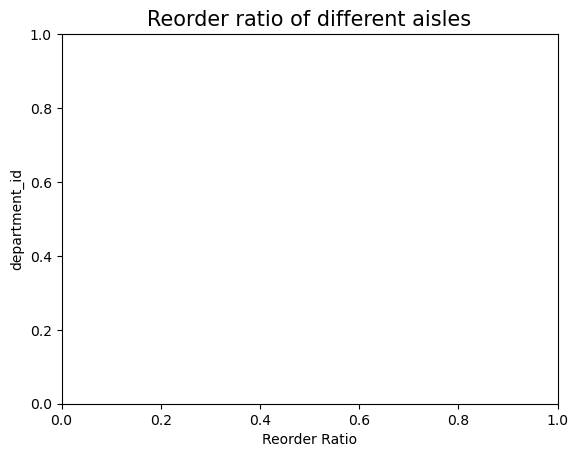

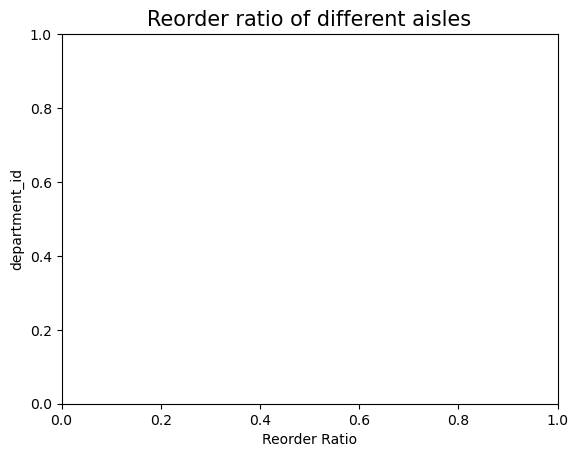

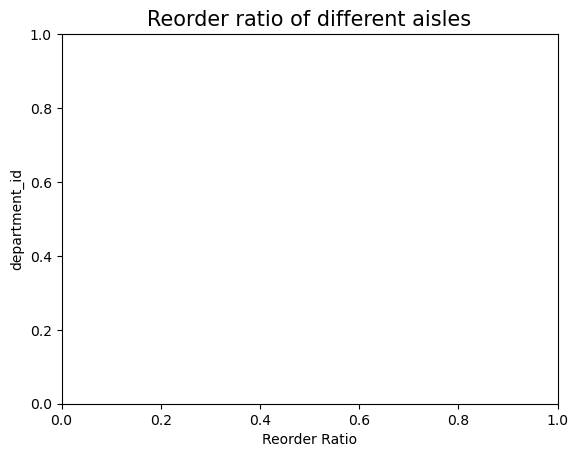

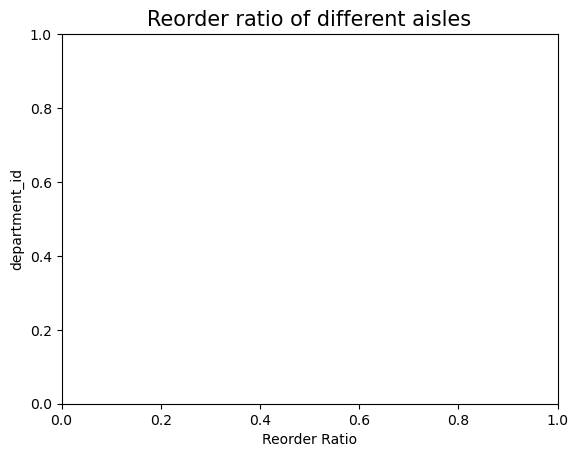

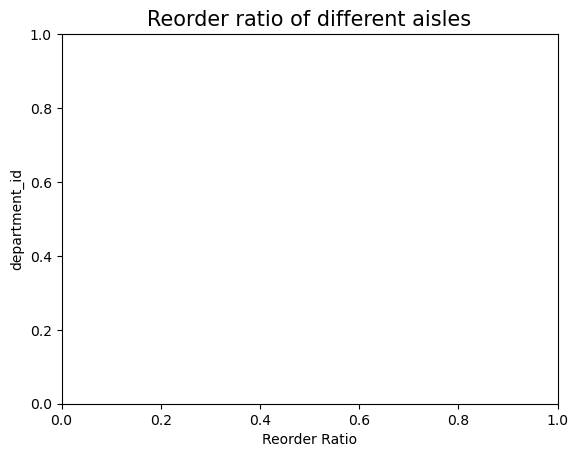

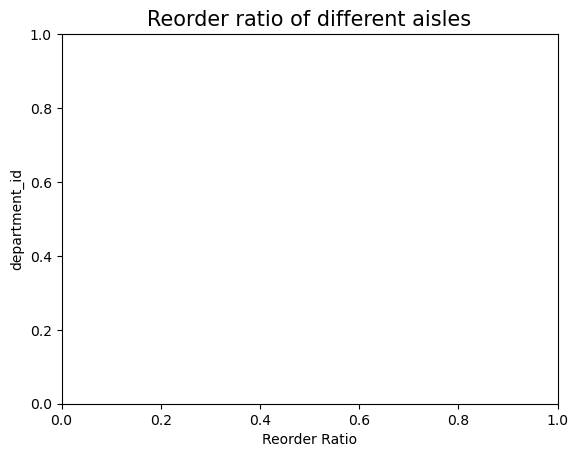

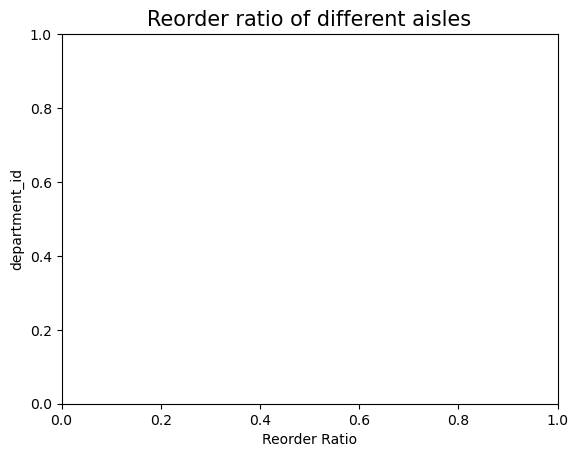

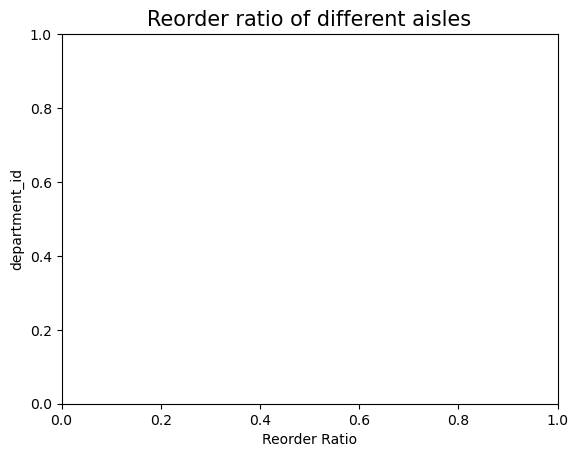

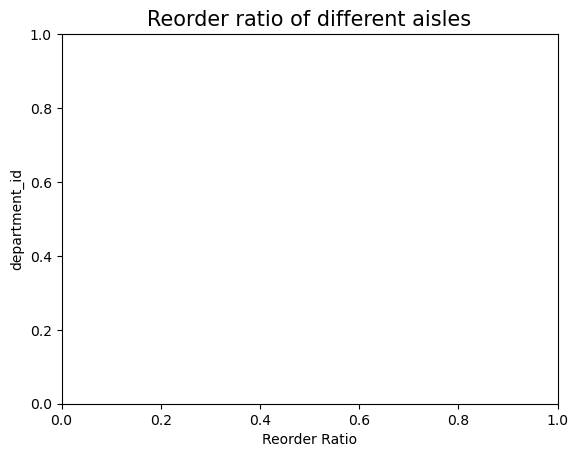

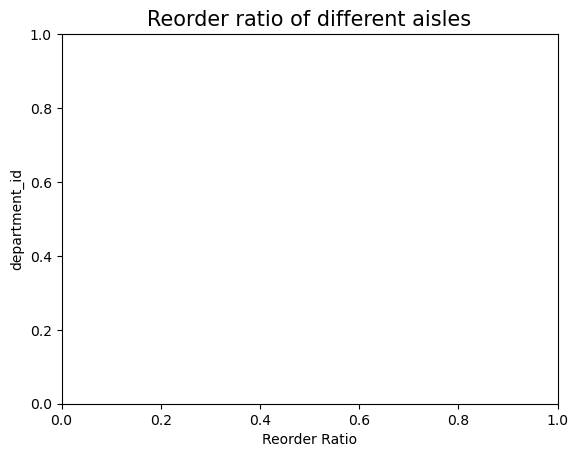

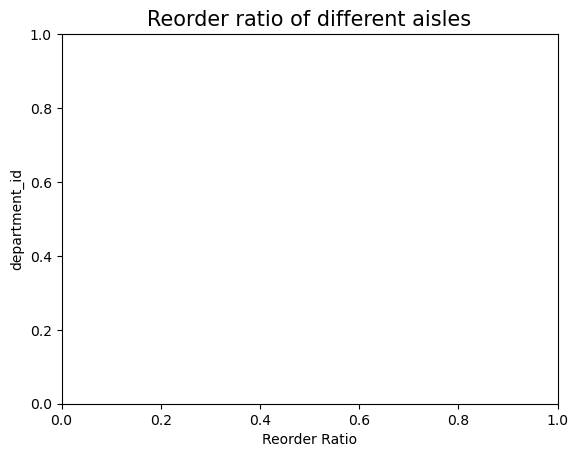

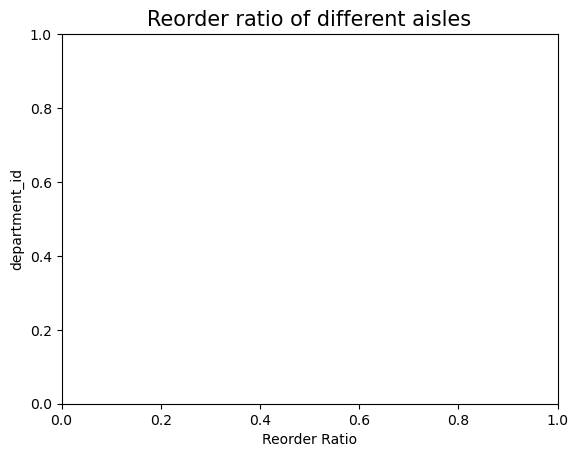

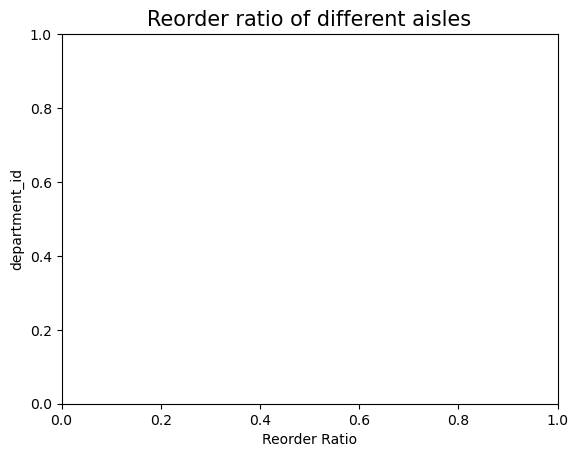

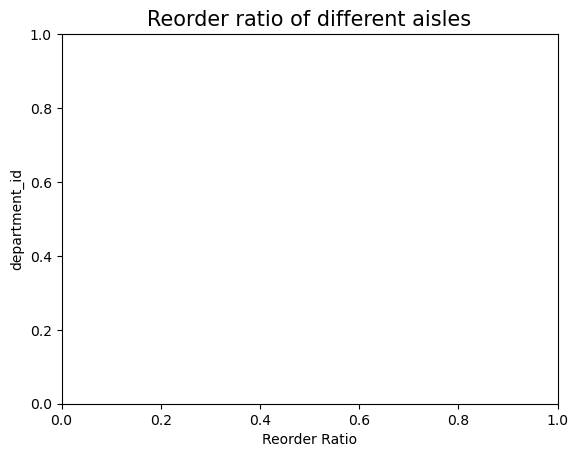

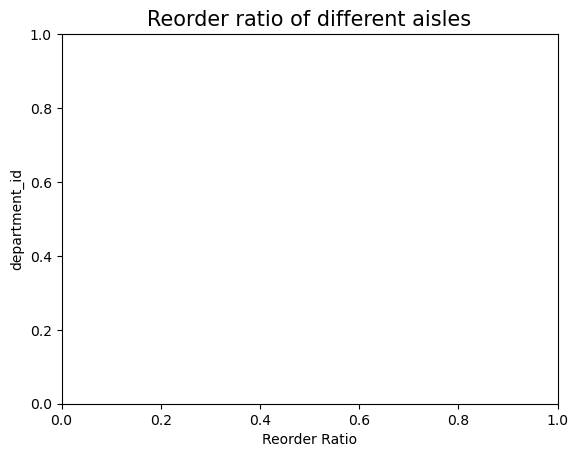

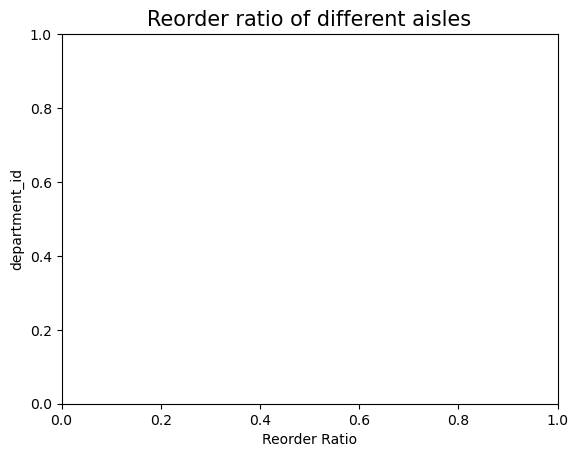

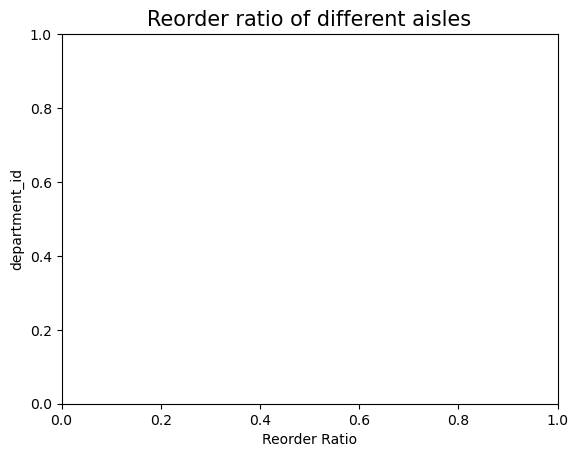

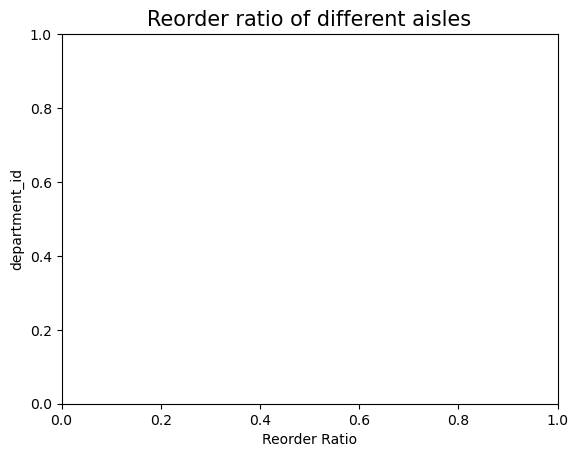

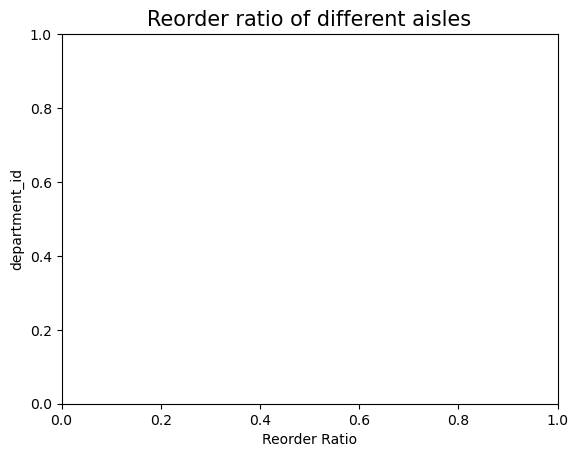

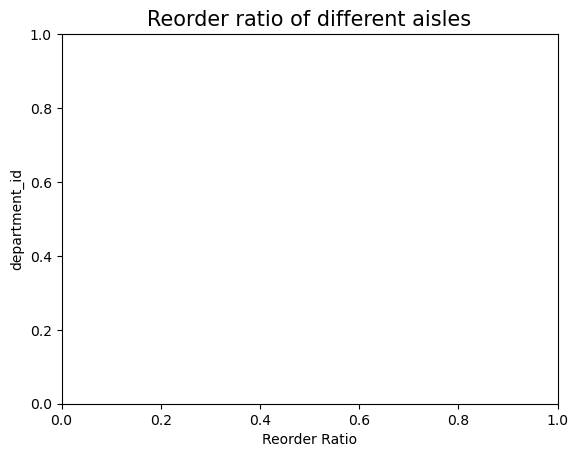

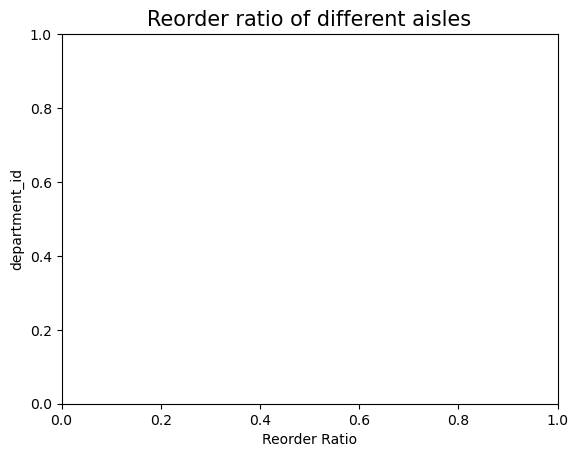

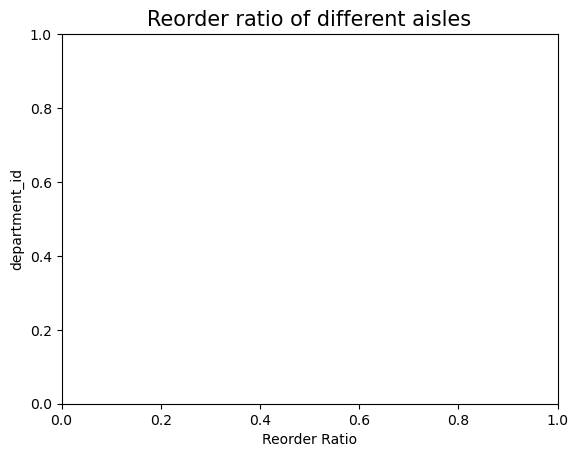

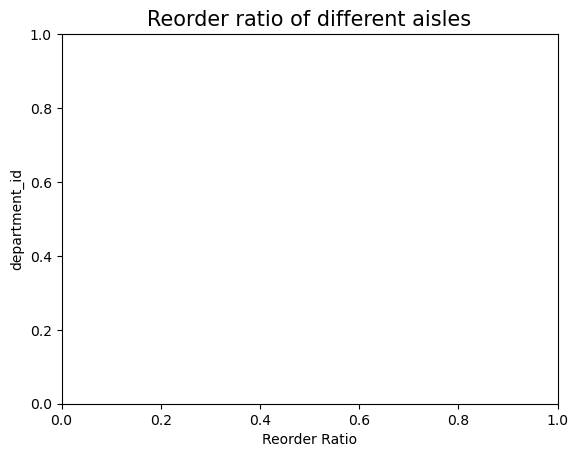

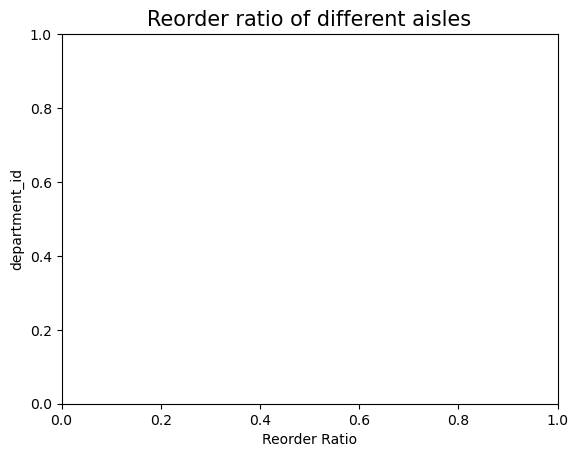

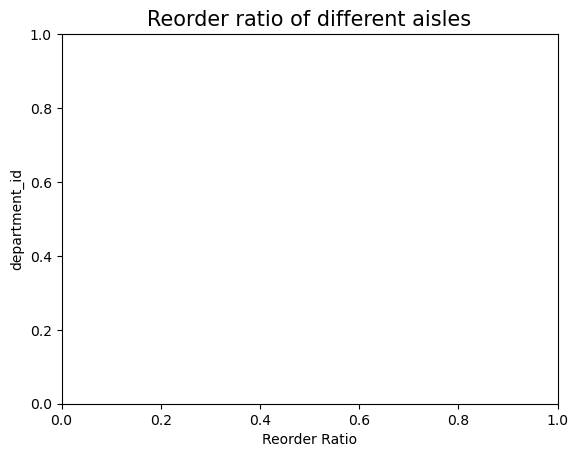

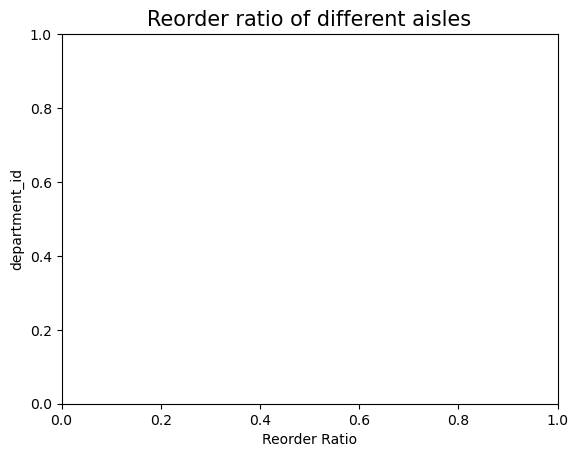

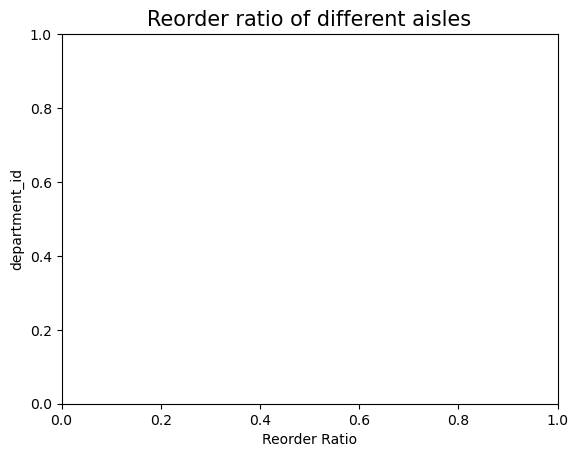

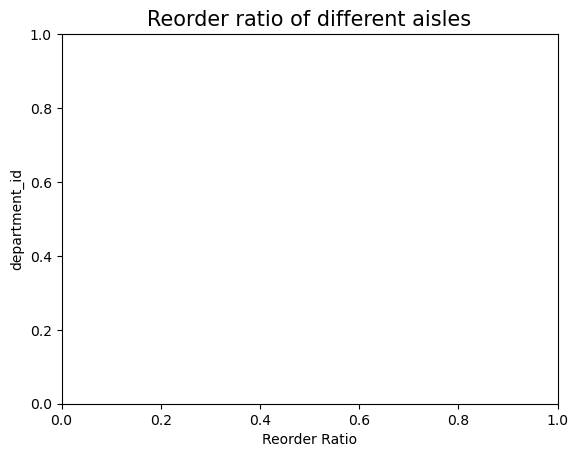

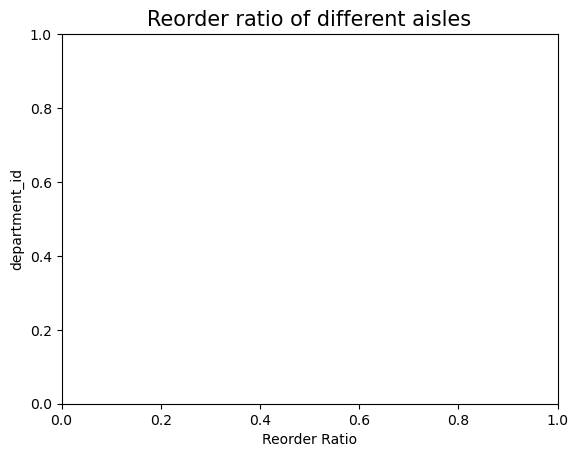

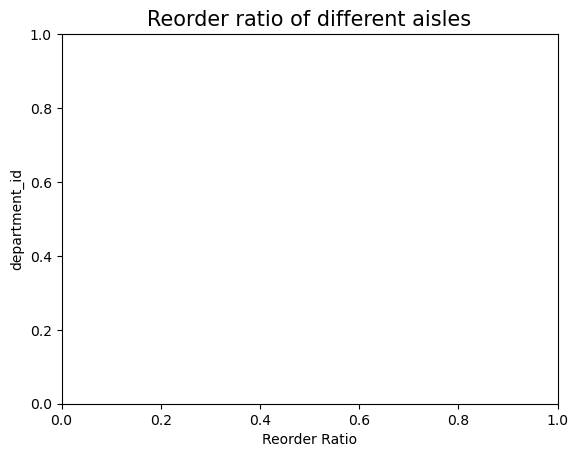

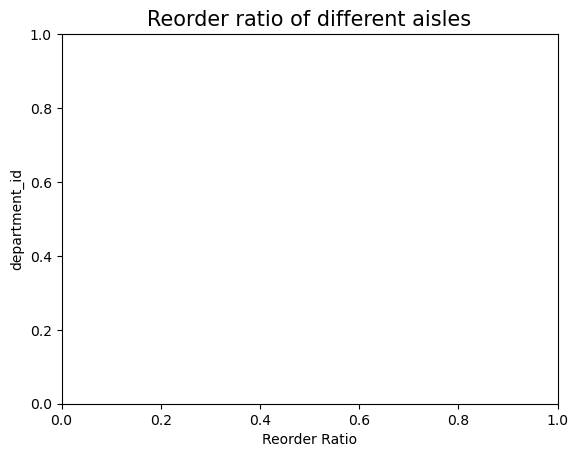

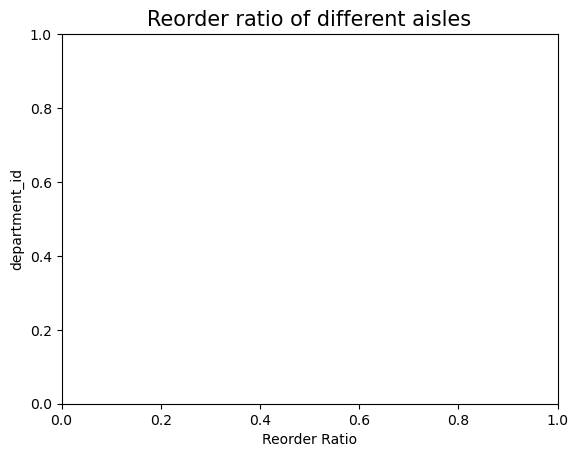

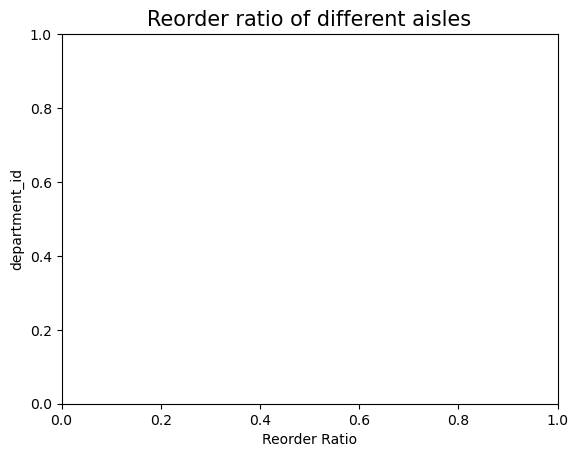

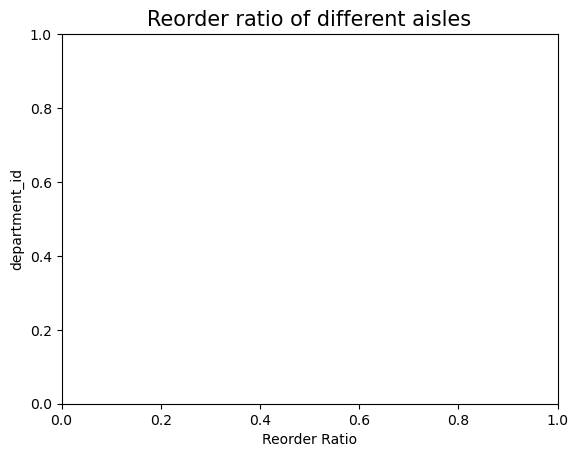

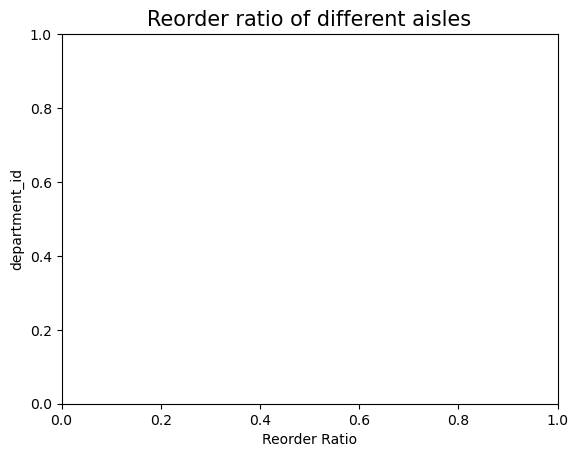

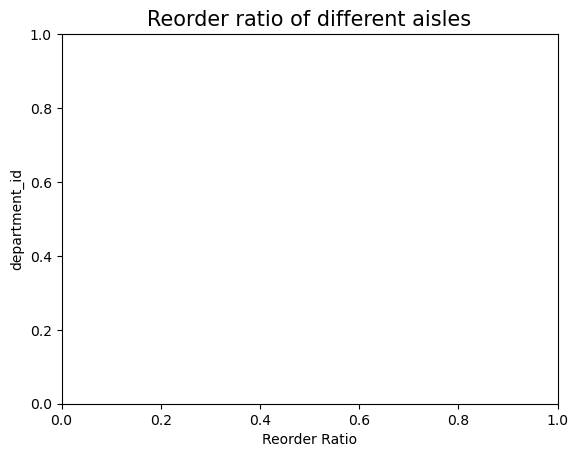

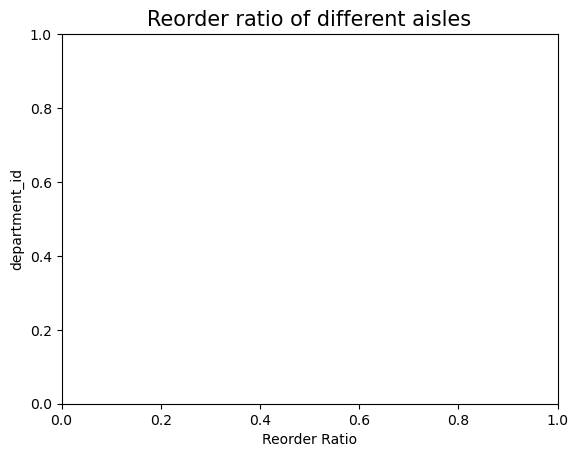

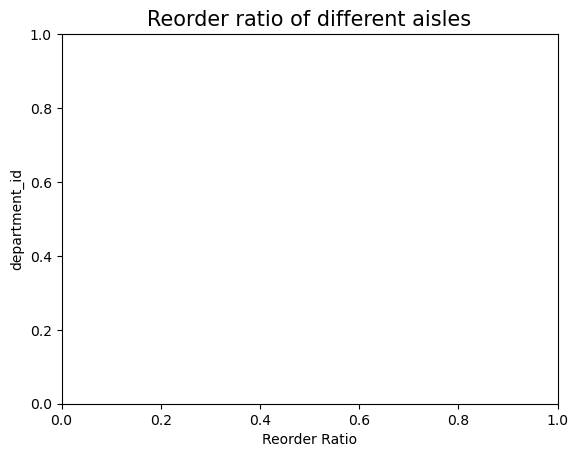

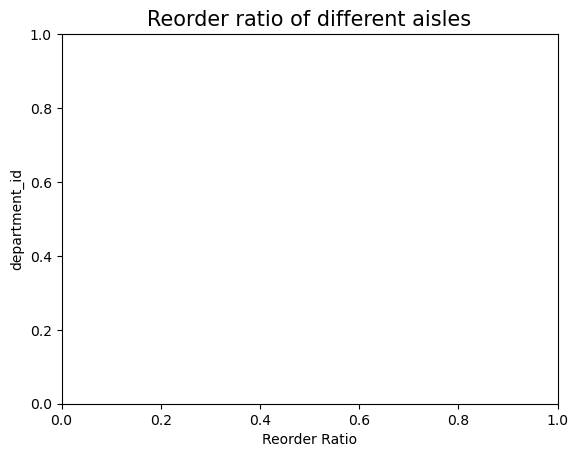

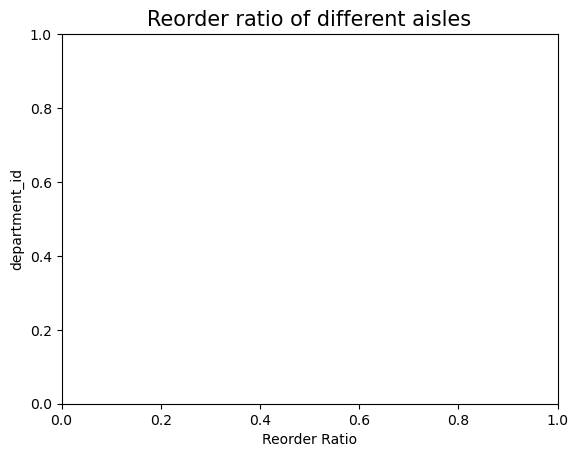

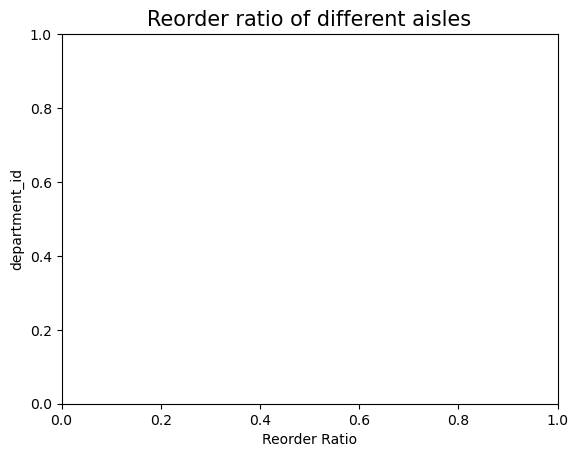

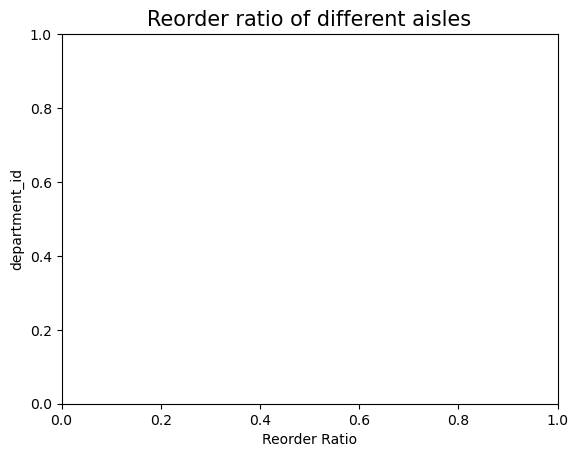

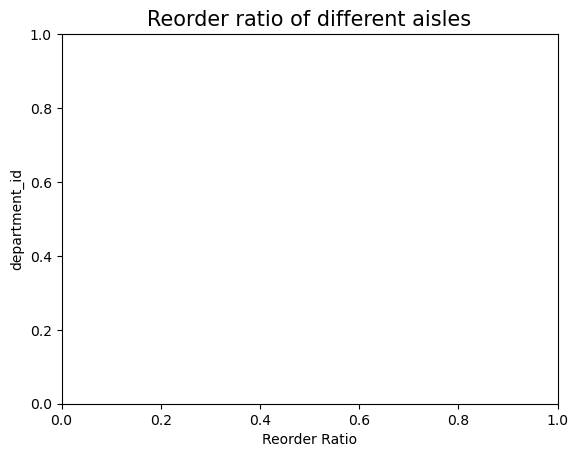

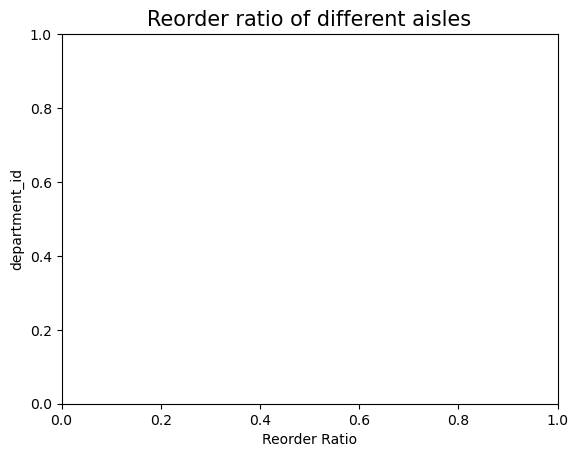

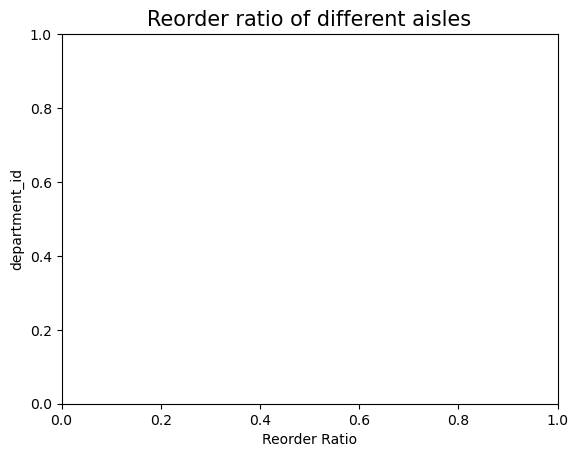

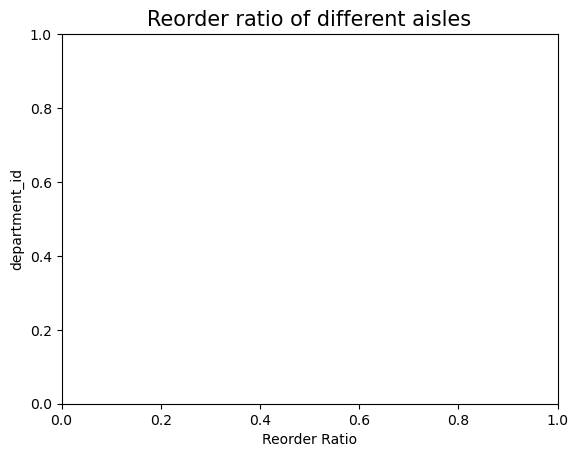

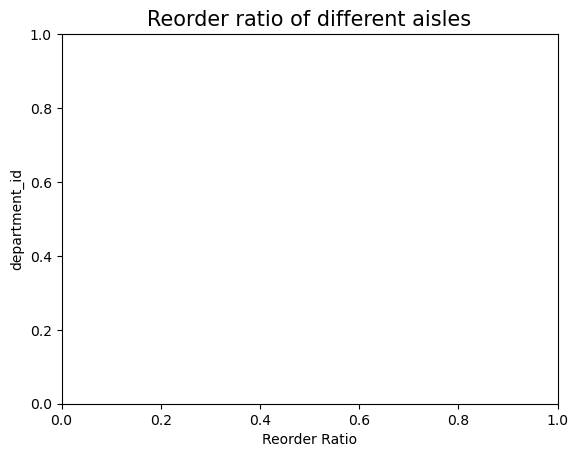

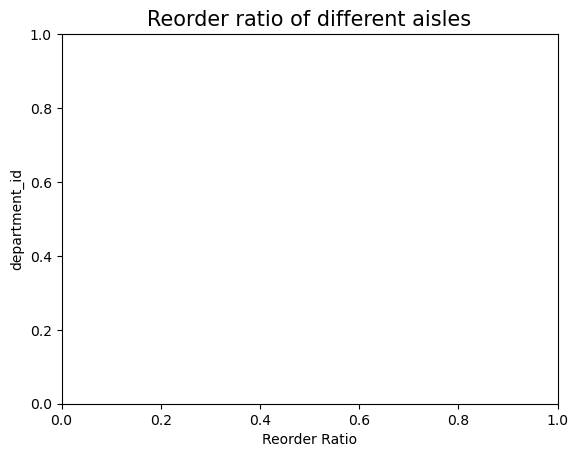

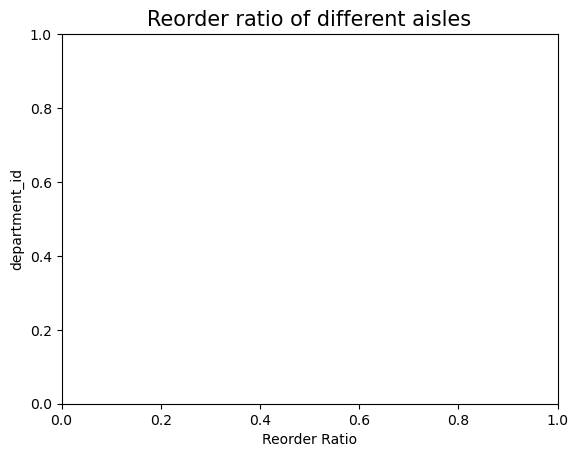

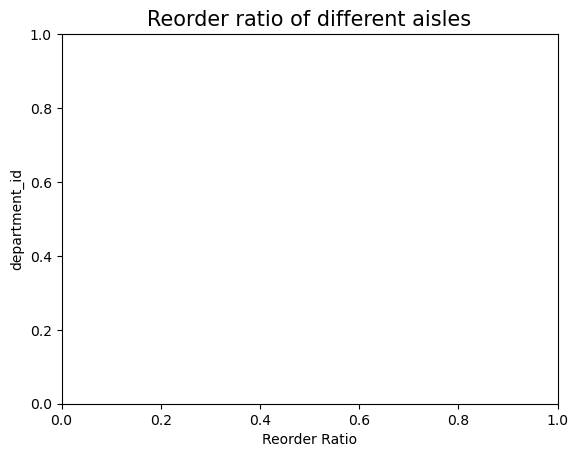

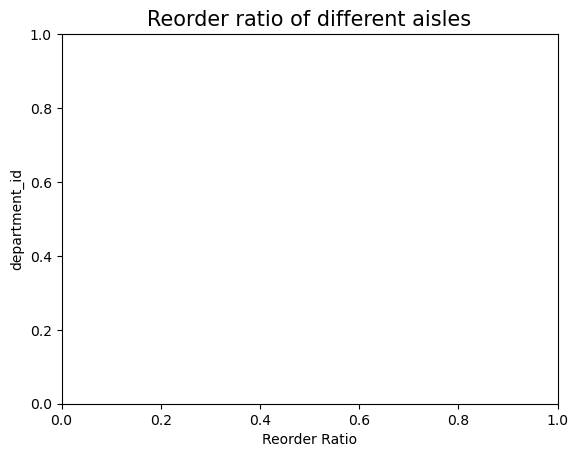

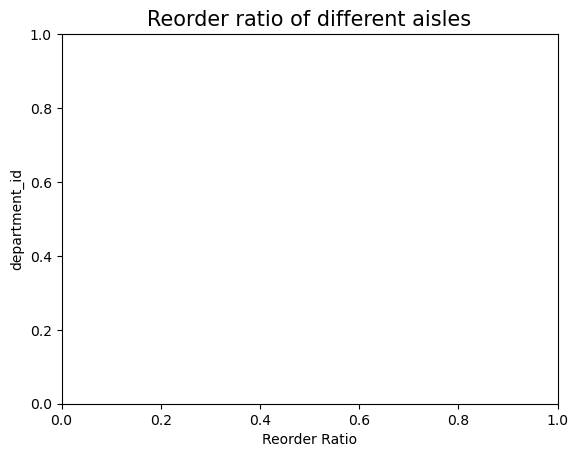

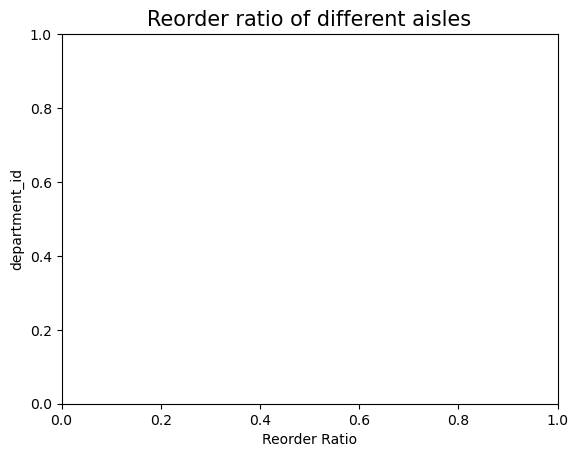

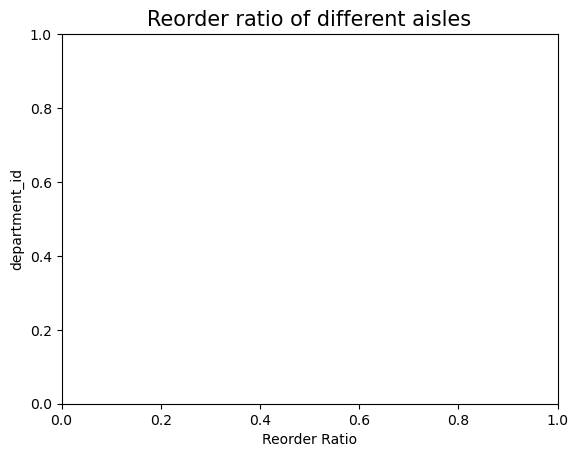

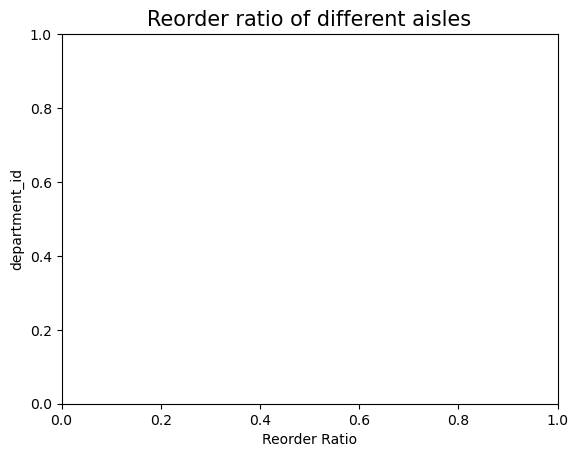

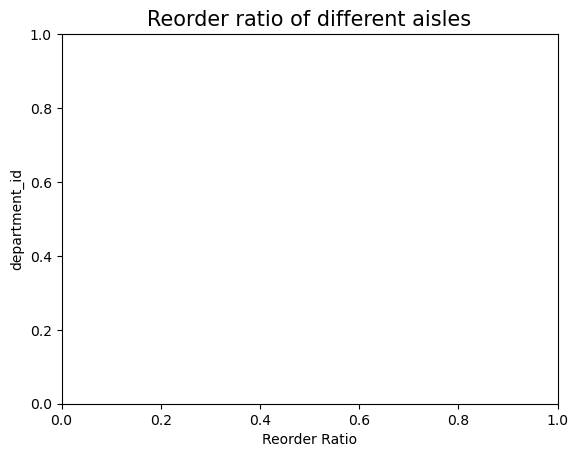

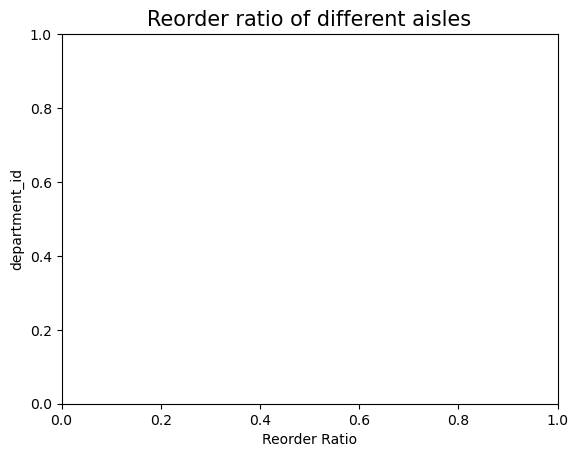

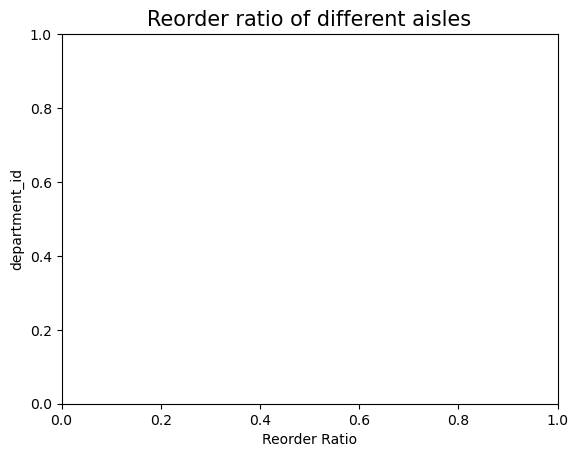

In [57]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='g')
    plt.xlabel('Reorder Ratio')
    plt.ylabel('department_id')
    plt.title("Reorder ratio of different aisles", fontsize=15)
    plt.show()

카트에 추가 - 재주문 비율:

이제 제품을 장바구니에 추가하는 순서가 재주문 비율에 어떤 영향을 미치는지 살펴보자.

/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_77159/3444702094.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70


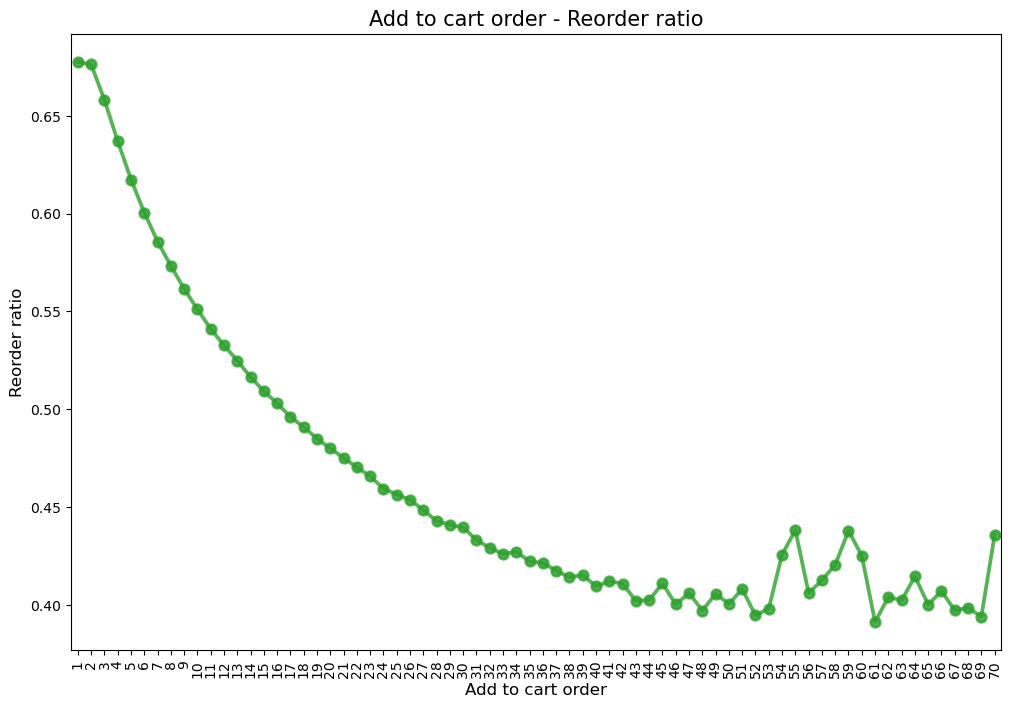

In [60]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

처음 장바구니에 추가된 제품은 나중에 추가된 제품에 비해 다시 주문할 가능성이 더 높은 것 같음.
우리는 자주 구매하던 모든 제품을 먼저 주문한 다음 새로운 제품을 찾는 경향을 보임.

시간 기반 변수별 재정렬 비율:

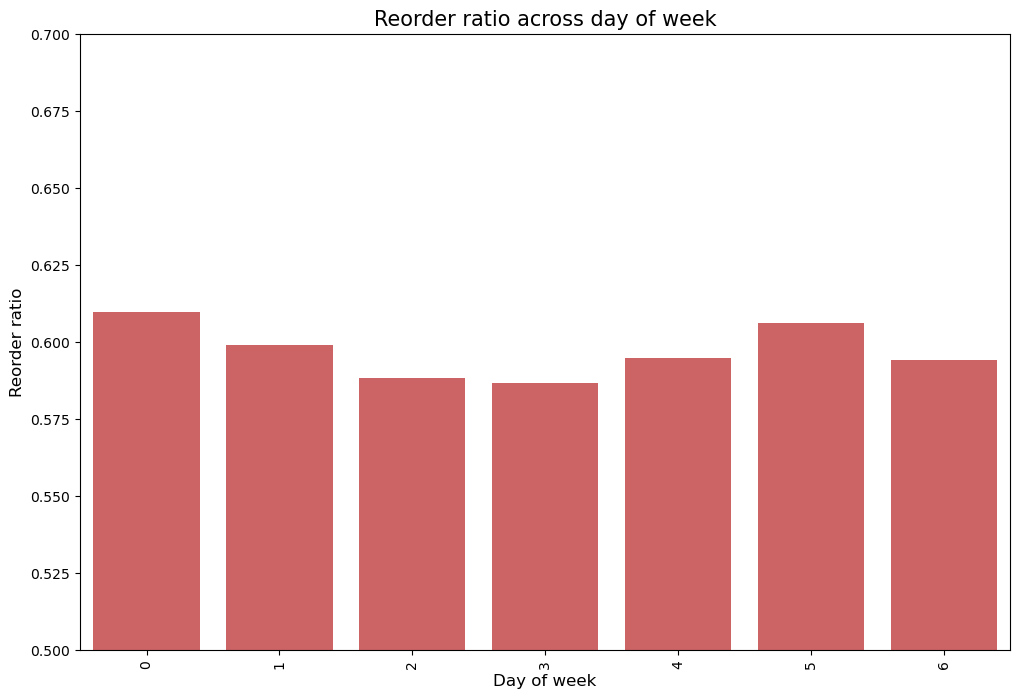

In [62]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

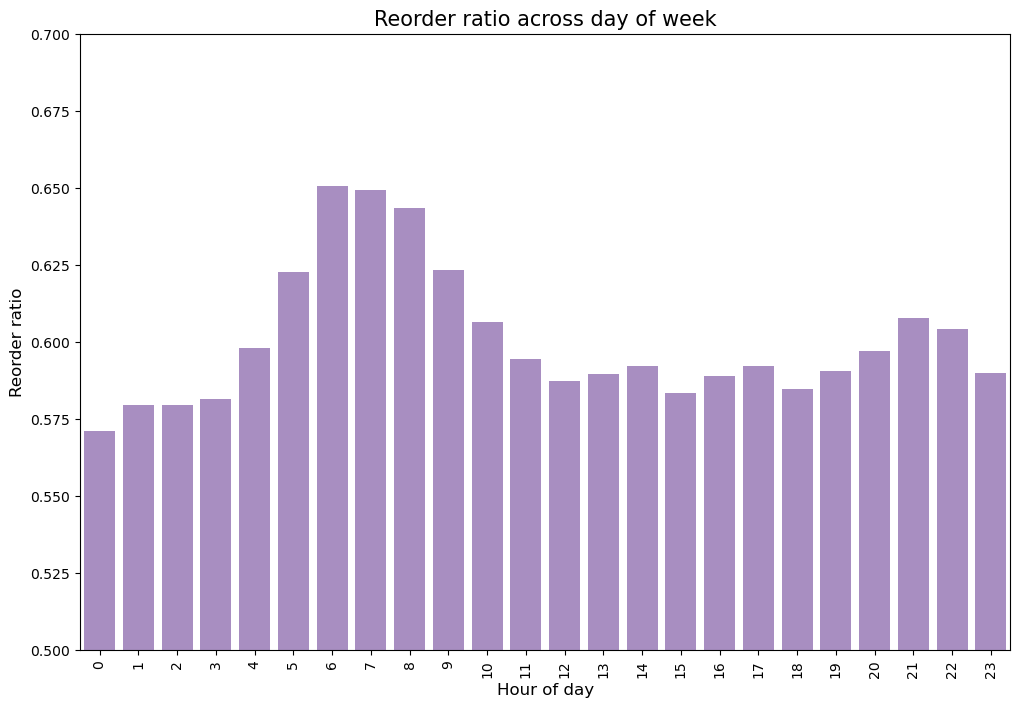

In [63]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

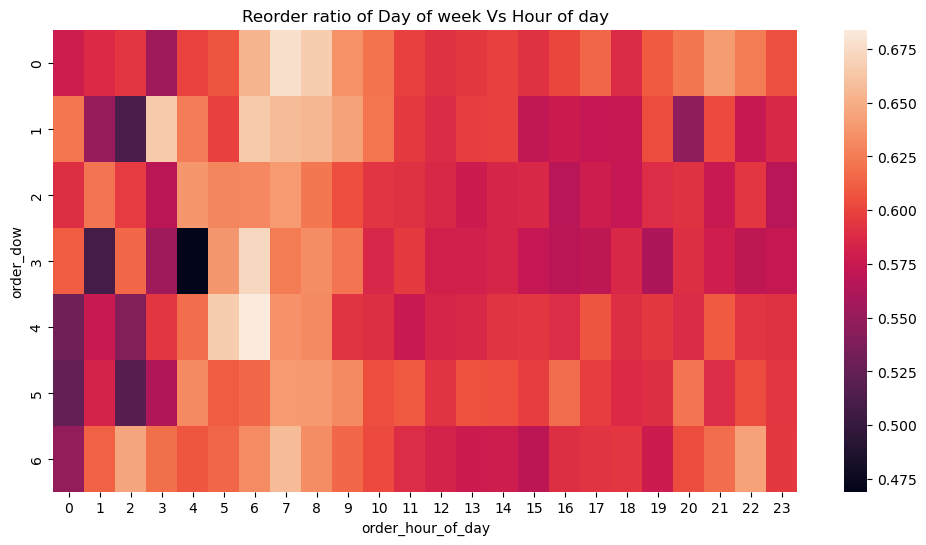

In [64]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

이른 아침에는 하루의 후반부에 비해 재주문 비율이 높음.

## + 추가 전처리/시각화

In [67]:
orders_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [68]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [19]:
order_products_train_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [21]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


### 카트 주문에 추가한 수가 많을수록 주문 수가 많을 것이다. (카트에 추가한 수와 주문 수가 비례할 것이다.)

In [77]:
# 데이터 병합
merged_df = orders_df.merge(order_products_train_df[['order_id', 'add_to_cart_order']], 
                            on='order_id', 
                            how='inner')

In [67]:
# 병합 결과 확인
merged_df.head(100)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order
0,1187899,1,train,11,4,8,14.0,1
1,1187899,1,train,11,4,8,14.0,2
2,1187899,1,train,11,4,8,14.0,3
3,1187899,1,train,11,4,8,14.0,4
4,1187899,1,train,11,4,8,14.0,5
...,...,...,...,...,...,...,...,...
95,1094988,9,train,4,6,10,30.0,18
96,1094988,9,train,4,6,10,30.0,19
97,1094988,9,train,4,6,10,30.0,20
98,1094988,9,train,4,6,10,30.0,21


/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_77696/2615036548.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x="add_to_cart_order", y='order_number', ci=None, data=merged_df, color=color[1])


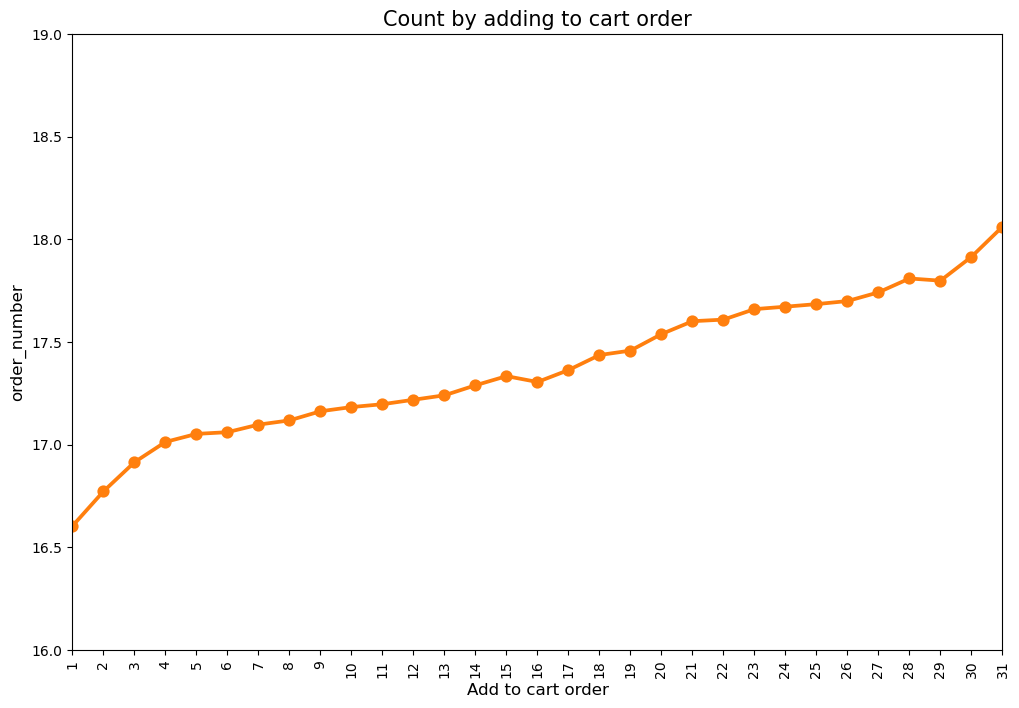

In [98]:
plt.figure(figsize=(12,8))
sns.pointplot(x="add_to_cart_order", y='order_number', ci=None, data=merged_df, color=color[1])
# pointplot은 각 점의 평균 값을 찍고, 신뢰 구간을 기준으로 에러 바가 생김
# 에러 바를 없애기 위해 ci=None을 추가
plt.ylabel('order_number', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count by adding to cart order", fontsize=15)
plt.ylim(16, 19)
plt.xlim(0, 30)
plt.show()

## 카트 주문 추가한 (물품)수가 많을수록 주문 수도 많음을 확인할 수 있다.